# Import Libraries

In [1]:
import tensorflow as tf
# from tensorflow.python.client import device_lib

2023-04-18 15:21:37.325495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-04-18 15:23:38.653294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 15:23:43.665019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 15:23:43.666522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 15:23:43.732592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

In [3]:
import os
import sys
import gc
#import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, LSTM, TimeDistributed, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import keras.utils as image

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

In [5]:
tf.test.is_built_with_cuda()

True

In [5]:
gc.collect()

8

# Set Constants

In [14]:
# Define constants
CATEGORIES = ['dining', 'drawing', 'mopping_floor', 'reading_book', 'running_on_treadmill','sleeping','watching_tv']
NUM_CLASSES = len(CATEGORIES)
INPUT_SHAPE = (40, 112, 112, 3)  # (frames, height, width, channels)
BATCH_SIZE = 4
EPOCHS = 30
random_state = 42

# Load Dataset

### Load Train and validation from processed numpy

#### 40fps

In [6]:
def read_dataset_40f(extractor):
    X_train = np.load('/home/jeheng/Desktop/numpy/Train_data_processed/' + extractor + '/X_train.npy')
    print('Loaded X_train')
    y_train = np.load('/home/jeheng/Desktop/numpy/Train_data_processed/' + extractor + '/y_train.npy')
    print('Loaded y_train')
    X_test = np.load('/home/jeheng/Desktop/numpy/Train_data_processed/' + extractor + '/X_test.npy')
    print('Loaded X_test')
    y_test = np.load('/home/jeheng/Desktop/numpy/Train_data_processed/' + extractor + '/y_test.npy')
    print('Loaded y_test')
    
    print("Shape of X_train: ", X_train.shape)
    print("Shape of y_train: ", y_train.shape)
    print("Shape of X_test: ", X_test.shape)
    print("Shape of y_test: ", y_test.shape)
    
    gc.collect()
    
    return X_train, y_train, X_test, y_test

#### 20fps

In [7]:
def read_dataset_20f(extractor):
    X_train = np.load('/home/jeheng/Desktop/numpy/Train_data_processed_20f/' + extractor + '/X_train.npy')
    print('Loaded X_train')
    y_train = np.load('/home/jeheng/Desktop/numpy/Train_data_processed_20f/' + extractor + '/y_train.npy')
    print('Loaded y_train')
    X_test = np.load('/home/jeheng/Desktop/numpy/Train_data_processed_20f/' + extractor + '/X_test.npy')
    print('Loaded X_test')
    y_test = np.load('/home/jeheng/Desktop/numpy/Train_data_processed_20f/' + extractor + '/y_test.npy')
    print('Loaded y_test')
    
    print("Shape of X_train: ", X_train.shape)
    print("Shape of y_train: ", y_train.shape)
    print("Shape of X_test: ", X_test.shape)
    print("Shape of y_test: ", y_test.shape)
    
    gc.collect()
    
    return X_train, y_train, X_test, y_test

### Load Evaluation from processed numpy

In [8]:
def read_evaldataset_40f(extractor):
    X_eval = np.load('/home/jeheng/Desktop/numpy/Validate_data_processed/' + extractor + '/X_eval.npy')
    y_eval = np.load('/home/jeheng/Desktop/numpy/Validate_data_processed/' + extractor + '/y_eval.npy')

    print(X_eval.shape)
    print(y_eval.shape)
    
    gc.collect()
    
    return X_eval, y_eval

In [9]:
def one_hot(y):
    y[y == 'dining'] = 0
    y[y == 'drawing'] = 1
    y[y == 'mopping_floor'] = 2
    y[y == 'reading_book'] = 3
    y[y == 'running_on_treadmill'] = 4
    y[y == 'sleeping'] = 5
    y[y == 'watching_tv'] = 6
    
    y_encode = to_categorical(y, num_classes=7)

    print("Shape of y_encode: ", y_encode.shape)
    
    return y_encode

# Running on Different model setup

# 40 f

## Setup 1: Default

### Resnet_gavg

In [11]:
#### Model setup:
Extractor = 'resnet_gavg'
Layer = '128_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [12]:
X_train, y_train, X_test, y_test = read_dataset_40f('resnet_gavg')

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8769, 40, 2048)
Shape of y_train:  (8769, 7)
Shape of X_test:  (2191, 40, 2048)
Shape of y_test:  (2191, 7)


In [13]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 1,115,527
Trainable params: 1,115,527
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])

2023-04-18 11:18:35.527245: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2873425920 exceeds 10% of free system memory.
2023-04-18 11:18:37.602430: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2873425920 exceeds 10% of free system memory.


Epoch 1/30


2023-04-18 11:18:53.765125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-18 11:18:56.920197: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7ff2881584c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-18 11:18:56.920292: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce GTX 1080, Compute Capability 6.1
2023-04-18 11:18:58.055101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-18 11:19:02.633020: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often

   1/2193 [..............................] - ETA: 14:26:01 - loss: 2.1391 - accuracy: 0.0000e+00

2023-04-18 11:19:03.030656: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-04-18 11:19:03.189016: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


2191/2193 [============================>.] - ETA: 0s - loss: 1.8363 - accuracy: 0.2427

2023-04-18 11:19:11.438239: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 717946880 exceeds 10% of free system memory.
2023-04-18 11:19:11.917350: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 717946880 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 1.78711, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 37s 6ms/step - loss: 1.8362 - accuracy: 0.2428 - val_loss: 1.7871 - val_accuracy: 0.2524 - lr: 0.0010
Epoch 2/30
2187/2193 [============================>.] - ETA: 0s - loss: 1.7334 - accuracy: 0.3066
Epoch 2: val_loss improved from 1.78711 to 1.71467, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.7335 - accuracy: 0.3064 - val_loss: 1.7147 - val_accuracy: 0.3145 - lr: 0.0010
Epoch 3/30
2188/2193 [============================>.] - ETA: 0s - loss: 1.6931 - accuracy: 0.3246
Epoch 3: val_loss improved from 1.71467 to 1.65260, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.6939 - accuracy: 0.3244 - val_loss: 1.6526 - val_accuracy: 0.3524 - lr: 0.0010
Epoch 4/30
2185/2193 [============================>.] - ETA: 0s - loss: 1.6672 - accuracy: 0.3370
Epoch 4: val_loss did not improve from 1.65260
2193/2193 [==============================] - 10s 4ms/step - loss: 1.6676 - accuracy: 0.3369 - val_loss: 1.6532 - val_accuracy: 0.3510 - lr: 0.0010
Epoch 5/30
2185/2193 [============================>.] - ETA: 0s - loss: 1.6468 - accuracy: 0.3535
Epoch 5: val_loss did not improve from 1.65260
2193/2193 [==============================] - 10s 4ms/step - loss: 1.6473 - accuracy: 0.3537 - val_loss: 1.7147 - val_accuracy: 0.3026 - lr: 0.0010
Epoch 6/30
2191/2193 [============================>.] - ETA: 0s - loss: 1.6255 - accuracy: 0.3648
Epoch 6: val_loss improved from 1.65260 to 1.65233, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.6254 - accuracy: 0.3650 - val_loss: 1.6523 - val_accuracy: 0.3391 - lr: 0.0010
Epoch 7/30
2186/2193 [============================>.] - ETA: 0s - loss: 1.6046 - accuracy: 0.3684
Epoch 7: val_loss improved from 1.65233 to 1.59482, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.6046 - accuracy: 0.3686 - val_loss: 1.5948 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 8/30
2189/2193 [============================>.] - ETA: 0s - loss: 1.5970 - accuracy: 0.3725
Epoch 8: val_loss improved from 1.59482 to 1.58447, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.5967 - accuracy: 0.3729 - val_loss: 1.5845 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 9/30
2181/2193 [============================>.] - ETA: 0s - loss: 1.5798 - accuracy: 0.3863
Epoch 9: val_loss did not improve from 1.58447
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5807 - accuracy: 0.3857 - val_loss: 1.6938 - val_accuracy: 0.3355 - lr: 0.0010
Epoch 10/30
2185/2193 [============================>.] - ETA: 0s - loss: 1.5723 - accuracy: 0.3890
Epoch 10: val_loss did not improve from 1.58447
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5727 - accuracy: 0.3885 - val_loss: 1.5911 - val_accuracy: 0.3925 - lr: 0.0010
Epoch 11/30
2186/2193 [============================>.] - ETA: 0s - loss: 1.5615 - accuracy: 0.3928
Epoch 11: val_loss did not improve from 1.58447
2193/2193 [==============================] - 10s 5ms/step - loss: 1.5617 - accuracy: 0.3926 - val_loss: 1.6291 - val_acc

INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 13s 6ms/step - loss: 1.5469 - accuracy: 0.4015 - val_loss: 1.5804 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 13/30
2186/2193 [============================>.] - ETA: 0s - loss: 1.5431 - accuracy: 0.4036
Epoch 13: val_loss improved from 1.58039 to 1.57008, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.5425 - accuracy: 0.4039 - val_loss: 1.5701 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 14/30
2184/2193 [============================>.] - ETA: 0s - loss: 1.5270 - accuracy: 0.4166
Epoch 14: val_loss did not improve from 1.57008
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5269 - accuracy: 0.4167 - val_loss: 1.6632 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 15/30
2190/2193 [============================>.] - ETA: 0s - loss: 1.5246 - accuracy: 0.4171
Epoch 15: val_loss did not improve from 1.57008
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5246 - accuracy: 0.4175 - val_loss: 1.5981 - val_accuracy: 0.3957 - lr: 0.0010
Epoch 16/30
2191/2193 [============================>.] - ETA: 0s - loss: 1.5111 - accuracy: 0.4184
Epoch 16: val_loss did not improve from 1.57008
2193/2193 [==============================] - 10s 5ms/step - loss: 1.5111 - accuracy: 0.4184 - val_loss: 1.5987 - val_a

INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.4314 - accuracy: 0.4558 - val_loss: 1.5282 - val_accuracy: 0.4404 - lr: 2.0000e-04
Epoch 20/30
2186/2193 [============================>.] - ETA: 0s - loss: 1.4178 - accuracy: 0.4685
Epoch 20: val_loss improved from 1.52821 to 1.52453, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.4180 - accuracy: 0.4684 - val_loss: 1.5245 - val_accuracy: 0.4427 - lr: 2.0000e-04
Epoch 21/30
2189/2193 [============================>.] - ETA: 0s - loss: 1.4106 - accuracy: 0.4685
Epoch 21: val_loss did not improve from 1.52453
2193/2193 [==============================] - 10s 4ms/step - loss: 1.4104 - accuracy: 0.4686 - val_loss: 1.5256 - val_accuracy: 0.4455 - lr: 2.0000e-04
Epoch 22/30
2192/2193 [============================>.] - ETA: 0s - loss: 1.4059 - accuracy: 0.4770
Epoch 22: val_loss improved from 1.52453 to 1.51941, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 13s 6ms/step - loss: 1.4058 - accuracy: 0.4770 - val_loss: 1.5194 - val_accuracy: 0.4313 - lr: 2.0000e-04
Epoch 23/30
2189/2193 [============================>.] - ETA: 0s - loss: 1.4086 - accuracy: 0.4652
Epoch 23: val_loss did not improve from 1.51941
2193/2193 [==============================] - 10s 5ms/step - loss: 1.4088 - accuracy: 0.4653 - val_loss: 1.5225 - val_accuracy: 0.4455 - lr: 2.0000e-04
Epoch 24/30
2192/2193 [============================>.] - ETA: 0s - loss: 1.3978 - accuracy: 0.4760
Epoch 24: val_loss improved from 1.51941 to 1.50742, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.3979 - accuracy: 0.4760 - val_loss: 1.5074 - val_accuracy: 0.4509 - lr: 2.0000e-04
Epoch 25/30
2192/2193 [============================>.] - ETA: 0s - loss: 1.3928 - accuracy: 0.4742
Epoch 25: val_loss did not improve from 1.50742
2193/2193 [==============================] - 10s 5ms/step - loss: 1.3927 - accuracy: 0.4743 - val_loss: 1.5211 - val_accuracy: 0.4391 - lr: 2.0000e-04
Epoch 26/30
2185/2193 [============================>.] - ETA: 0s - loss: 1.3874 - accuracy: 0.4733
Epoch 26: val_loss improved from 1.50742 to 1.50699, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.3871 - accuracy: 0.4733 - val_loss: 1.5070 - val_accuracy: 0.4441 - lr: 2.0000e-04
Epoch 27/30
2193/2193 [==============================] - ETA: 0s - loss: 1.3886 - accuracy: 0.4815
Epoch 27: val_loss did not improve from 1.50699
2193/2193 [==============================] - 10s 5ms/step - loss: 1.3886 - accuracy: 0.4815 - val_loss: 1.5073 - val_accuracy: 0.4518 - lr: 2.0000e-04
Epoch 28/30
2180/2193 [============================>.] - ETA: 0s - loss: 1.3746 - accuracy: 0.4814
Epoch 28: val_loss improved from 1.50699 to 1.50236, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.3751 - accuracy: 0.4808 - val_loss: 1.5024 - val_accuracy: 0.4523 - lr: 2.0000e-04
Epoch 29/30
2187/2193 [============================>.] - ETA: 0s - loss: 1.3720 - accuracy: 0.4849
Epoch 29: val_loss did not improve from 1.50236
2193/2193 [==============================] - 10s 4ms/step - loss: 1.3723 - accuracy: 0.4848 - val_loss: 1.5031 - val_accuracy: 0.4436 - lr: 2.0000e-04
Epoch 30/30
2182/2193 [============================>.] - ETA: 0s - loss: 1.3668 - accuracy: 0.4845
Epoch 30: val_loss did not improve from 1.50236
2193/2193 [==============================] - 10s 4ms/step - loss: 1.3668 - accuracy: 0.4848 - val_loss: 1.5331 - val_accuracy: 0.4377 - lr: 2.0000e-04


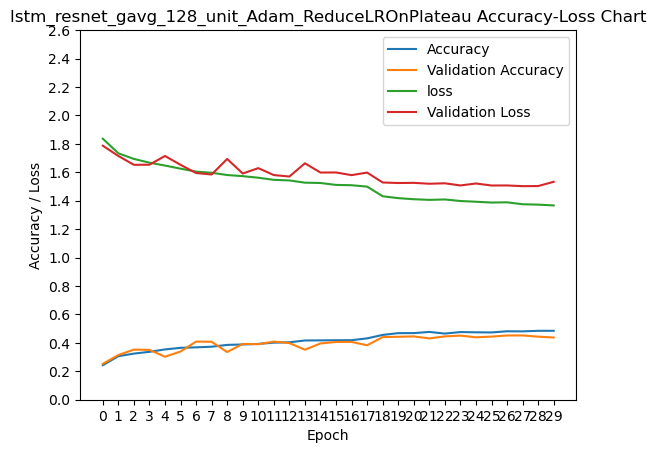

In [15]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


In [40]:
X_eval, y_eval = read_evaldataset_40f('resnet_gavg')

(678, 40, 2048)
(678, 7)


In [41]:
y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

170/170 [==============================] - 0s 3ms/step


(678, 7)

In [42]:
confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1))

array([[30,  1,  4, 26, 19,  5, 13],
       [ 3, 49, 12,  9,  0, 16,  3],
       [ 7,  6, 26, 12,  9, 12, 28],
       [11,  4, 10, 28, 12, 14, 19],
       [14,  3, 12, 17, 24,  6, 20],
       [ 7,  7, 10, 22,  2, 38, 10],
       [ 8,  2, 10,  9,  6,  6, 57]])

In [43]:
print(classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.38      0.31      0.34        98
           1       0.68      0.53      0.60        92
           2       0.31      0.26      0.28       100
           3       0.23      0.29      0.25        98
           4       0.33      0.25      0.29        96
           5       0.39      0.40      0.39        96
           6       0.38      0.58      0.46        98

    accuracy                           0.37       678
   macro avg       0.39      0.37      0.37       678
weighted avg       0.38      0.37      0.37       678



 ### VGG16_avg

In [44]:
#### Model setup:
Extractor = 'vgg16_avg'
Layer = '128_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [45]:
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_avg')

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8769, 40, 2048)
Shape of y_train:  (8769, 7)
Shape of X_test:  (2191, 40, 2048)
Shape of y_test:  (2191, 7)


In [46]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 1,115,527
Trainable params: 1,115,527
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])

Epoch 1/30
2193/2193 [==============================] - ETA: 0s - loss: 1.1955 - accuracy: 0.5702
Epoch 1: val_loss improved from inf to 1.05269, saving model to lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 23s 6ms/step - loss: 1.1955 - accuracy: 0.5702 - val_loss: 1.0527 - val_accuracy: 0.6312 - lr: 0.0010
Epoch 2/30
2181/2193 [============================>.] - ETA: 0s - loss: 0.8919 - accuracy: 0.6907
Epoch 2: val_loss improved from 1.05269 to 0.95942, saving model to lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 0.8910 - accuracy: 0.6912 - val_loss: 0.9594 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 3/30
2187/2193 [============================>.] - ETA: 0s - loss: 0.7790 - accuracy: 0.7337
Epoch 3: val_loss improved from 0.95942 to 0.93662, saving model to lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 0.7794 - accuracy: 0.7335 - val_loss: 0.9366 - val_accuracy: 0.6828 - lr: 0.0010
Epoch 4/30
2185/2193 [============================>.] - ETA: 0s - loss: 0.7125 - accuracy: 0.7497
Epoch 4: val_loss improved from 0.93662 to 0.90023, saving model to lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 13s 6ms/step - loss: 0.7128 - accuracy: 0.7495 - val_loss: 0.9002 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 5/30
2192/2193 [============================>.] - ETA: 0s - loss: 0.6380 - accuracy: 0.7794
Epoch 5: val_loss improved from 0.90023 to 0.89683, saving model to lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 0.6379 - accuracy: 0.7795 - val_loss: 0.8968 - val_accuracy: 0.6933 - lr: 0.0010
Epoch 6/30
2193/2193 [==============================] - ETA: 0s - loss: 0.5933 - accuracy: 0.7897
Epoch 6: val_loss did not improve from 0.89683
2193/2193 [==============================] - 10s 4ms/step - loss: 0.5933 - accuracy: 0.7897 - val_loss: 0.9199 - val_accuracy: 0.6928 - lr: 0.0010
Epoch 7/30
2192/2193 [============================>.] - ETA: 0s - loss: 0.5440 - accuracy: 0.8057
Epoch 7: val_loss did not improve from 0.89683
2193/2193 [==============================] - 10s 5ms/step - loss: 0.5439 - accuracy: 0.8057 - val_loss: 0.9397 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 8/30
2193/2193 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.8271
Epoch 8: val_loss did not improve from 0.89683
2193/2193 [==============================] - 10s 4ms/step - loss: 0.5000 - accuracy: 0.8271 - val_loss: 0.9596 - val_accurac

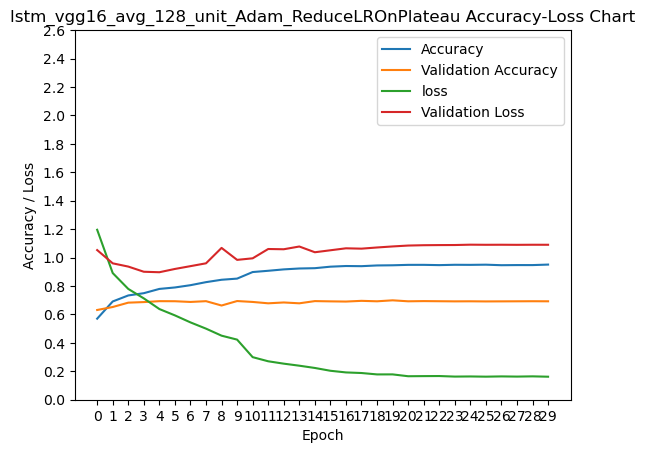

In [51]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


In [56]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_avg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 2048)
(678, 7)
170/170 [==============================] - 0s 2ms/step


(678, 7)

In [57]:
confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1))

array([[59,  1,  5, 18,  4,  6,  5],
       [ 1, 64, 10,  6,  5,  6,  0],
       [10,  4, 73,  0,  9,  1,  3],
       [ 9, 11,  8, 54,  5,  7,  4],
       [ 6,  4,  8, 13, 59,  1,  5],
       [ 0,  3,  7, 21,  2, 60,  3],
       [ 3,  2,  7, 12,  7,  3, 64]])

In [58]:
print(classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63        98
           1       0.72      0.70      0.71        92
           2       0.62      0.73      0.67       100
           3       0.44      0.55      0.49        98
           4       0.65      0.61      0.63        96
           5       0.71      0.62      0.67        96
           6       0.76      0.65      0.70        98

    accuracy                           0.64       678
   macro avg       0.65      0.64      0.64       678
weighted avg       0.65      0.64      0.64       678



 ### VGG16_gavg

In [63]:
#### Model setup:
Extractor = 'vgg16_gavg'
Layer = '128_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [66]:
#del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_gavg')

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8768, 40, 512)
Shape of y_train:  (8768, 7)
Shape of X_test:  (2192, 40, 512)
Shape of y_test:  (2192, 7)


In [67]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 512)]         0         
                                                                 
 lstm (LSTM)                 (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 329,095
Trainable params: 329,095
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
2189/2192 [============================>.] - ETA: 0s - loss: 1.2433 - accuracy: 0.5417
Epoch 1: val_loss improved from inf to 1.01082, saving model to lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 17s 5ms/step - loss: 1.2431 - accuracy: 0.5420 - val_loss: 1.0108 - val_accuracy: 0.6432 - lr: 0.0010
Epoch 2/30
2183/2192 [============================>.] - ETA: 0s - loss: 0.9558 - accuracy: 0.6637
Epoch 2: val_loss improved from 1.01082 to 0.91480, saving model to lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.9560 - accuracy: 0.6635 - val_loss: 0.9148 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 3/30
2189/2192 [============================>.] - ETA: 0s - loss: 0.8256 - accuracy: 0.7088
Epoch 3: val_loss improved from 0.91480 to 0.86492, saving model to lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.8256 - accuracy: 0.7087 - val_loss: 0.8649 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 4/30
2187/2192 [============================>.] - ETA: 0s - loss: 0.7516 - accuracy: 0.7370
Epoch 4: val_loss improved from 0.86492 to 0.85235, saving model to lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 5ms/step - loss: 0.7519 - accuracy: 0.7368 - val_loss: 0.8523 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 5/30
2180/2192 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.7636
Epoch 5: val_loss improved from 0.85235 to 0.77226, saving model to lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.6926 - accuracy: 0.7638 - val_loss: 0.7723 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 6/30
2180/2192 [============================>.] - ETA: 0s - loss: 0.6387 - accuracy: 0.7756
Epoch 6: val_loss did not improve from 0.77226
2192/2192 [==============================] - 7s 3ms/step - loss: 0.6375 - accuracy: 0.7761 - val_loss: 0.8171 - val_accuracy: 0.7235 - lr: 0.0010
Epoch 7/30
2178/2192 [============================>.] - ETA: 0s - loss: 0.5950 - accuracy: 0.7906
Epoch 7: val_loss improved from 0.77226 to 0.75395, saving model to lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.5955 - accuracy: 0.7905 - val_loss: 0.7539 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 8/30
2188/2192 [============================>.] - ETA: 0s - loss: 0.5467 - accuracy: 0.8075
Epoch 8: val_loss did not improve from 0.75395
2192/2192 [==============================] - 7s 3ms/step - loss: 0.5472 - accuracy: 0.8071 - val_loss: 0.7564 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 9/30
2181/2192 [============================>.] - ETA: 0s - loss: 0.5046 - accuracy: 0.8238
Epoch 9: val_loss did not improve from 0.75395
2192/2192 [==============================] - 7s 3ms/step - loss: 0.5043 - accuracy: 0.8241 - val_loss: 0.7982 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 10/30
2187/2192 [============================>.] - ETA: 0s - loss: 0.4740 - accuracy: 0.8350
Epoch 10: val_loss did not improve from 0.75395
2192/2192 [==============================] - 7s 3ms/step - loss: 0.4753 - accuracy: 0.8349 - val_loss: 0.7775 - val_accuracy

INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 5ms/step - loss: 0.2698 - accuracy: 0.9098 - val_loss: 0.7440 - val_accuracy: 0.7737 - lr: 2.0000e-04
Epoch 14/30
2191/2192 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.9196
Epoch 14: val_loss did not improve from 0.74398
2192/2192 [==============================] - 8s 4ms/step - loss: 0.2390 - accuracy: 0.9195 - val_loss: 0.7543 - val_accuracy: 0.7792 - lr: 2.0000e-04
Epoch 15/30
2188/2192 [============================>.] - ETA: 0s - loss: 0.2188 - accuracy: 0.9260
Epoch 15: val_loss did not improve from 0.74398
2192/2192 [==============================] - 7s 3ms/step - loss: 0.2190 - accuracy: 0.9259 - val_loss: 0.7979 - val_accuracy: 0.7746 - lr: 2.0000e-04
Epoch 16/30
2178/2192 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9303
Epoch 16: val_loss did not improve from 0.74398
2192/2192 [==============================] - 7s 3ms/step - loss: 0.2078 - accuracy: 0.9304 - val_loss: 0.803

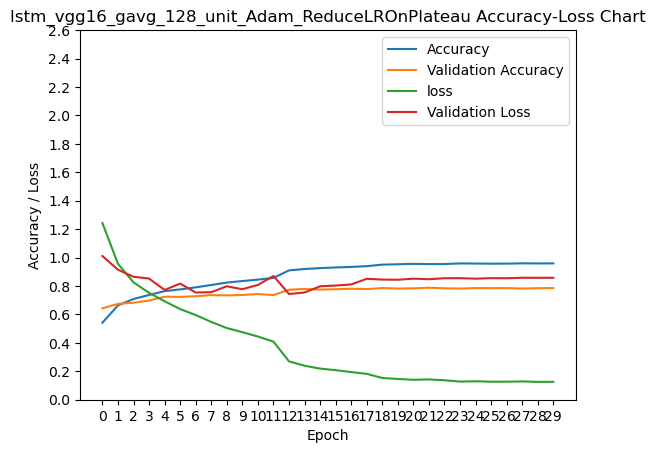

In [68]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [69]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_gavg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 512)
(678, 7)
170/170 [==============================] - 1s 1ms/step


(678, 7)

In [71]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[69  1  2 10  2  8  6]
 [ 2 74  1  6  6  1  2]
 [ 7  3 71  2 12  2  3]
 [13  9  6 55  4  7  4]
 [ 6  4  8  9 60  3  6]
 [ 3  4  6 15  6 60  2]
 [ 7  0  7 13  6  2 63]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.70      0.67        98
           1       0.78      0.80      0.79        92
           2       0.70      0.71      0.71       100
           3       0.50      0.56      0.53        98
           4       0.62      0.62      0.62        96
           5       0.72      0.62      0.67        96
           6       0.73      0.64      0.68        98

    accuracy                           0.67       678
   macro avg       0.67      0.67      0.67       678
weighted avg       0.67      0.67      0.67       678



## Setup 2: Batch size 16

### Resnet_gavg

In [73]:
#### Model setup:
Extractor = 'resnet_gavg'
Layer = '128_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '16'

In [76]:
del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('resnet_gavg')

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8769, 40, 2048)
Shape of y_train:  (8769, 7)
Shape of X_test:  (2191, 40, 2048)
Shape of y_test:  (2191, 7)


In [77]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 1,115,527
Trainable params: 1,115,527
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
546/549 [============================>.] - ETA: 0s - loss: 1.8456 - accuracy: 0.2382
Epoch 1: val_loss improved from inf to 1.76665, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 15s 18ms/step - loss: 1.8460 - accuracy: 0.2381 - val_loss: 1.7666 - val_accuracy: 0.3008 - lr: 0.0010
Epoch 2/30
544/549 [============================>.] - ETA: 0s - loss: 1.7339 - accuracy: 0.2993
Epoch 2: val_loss improved from 1.76665 to 1.70040, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 6s 12ms/step - loss: 1.7339 - accuracy: 0.2992 - val_loss: 1.7004 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 3/30
548/549 [============================>.] - ETA: 0s - loss: 1.6848 - accuracy: 0.3341
Epoch 3: val_loss improved from 1.70040 to 1.64049, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 6s 12ms/step - loss: 1.6847 - accuracy: 0.3341 - val_loss: 1.6405 - val_accuracy: 0.3651 - lr: 0.0010
Epoch 4/30
544/549 [============================>.] - ETA: 0s - loss: 1.6301 - accuracy: 0.3598
Epoch 4: val_loss improved from 1.64049 to 1.62043, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 7s 12ms/step - loss: 1.6301 - accuracy: 0.3596 - val_loss: 1.6204 - val_accuracy: 0.3825 - lr: 0.0010
Epoch 5/30
549/549 [==============================] - ETA: 0s - loss: 1.6004 - accuracy: 0.3800
Epoch 5: val_loss improved from 1.62043 to 1.60372, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 7s 12ms/step - loss: 1.6004 - accuracy: 0.3800 - val_loss: 1.6037 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 6/30
548/549 [============================>.] - ETA: 0s - loss: 1.5872 - accuracy: 0.3818
Epoch 6: val_loss improved from 1.60372 to 1.56951, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 6s 11ms/step - loss: 1.5872 - accuracy: 0.3818 - val_loss: 1.5695 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 7/30
547/549 [============================>.] - ETA: 0s - loss: 1.5605 - accuracy: 0.3975
Epoch 7: val_loss did not improve from 1.56951
549/549 [==============================] - 4s 7ms/step - loss: 1.5600 - accuracy: 0.3978 - val_loss: 1.6662 - val_accuracy: 0.3606 - lr: 0.0010
Epoch 8/30
547/549 [============================>.] - ETA: 0s - loss: 1.5450 - accuracy: 0.3976
Epoch 8: val_loss did not improve from 1.56951
549/549 [==============================] - 4s 7ms/step - loss: 1.5444 - accuracy: 0.3979 - val_loss: 1.5966 - val_accuracy: 0.3765 - lr: 0.0010
Epoch 9/30
541/549 [============================>.] - ETA: 0s - loss: 1.5307 - accuracy: 0.4136
Epoch 9: val_loss improved from 1.56951 to 1.53817, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 7s 12ms/step - loss: 1.5325 - accuracy: 0.4128 - val_loss: 1.5382 - val_accuracy: 0.4272 - lr: 0.0010
Epoch 10/30
549/549 [==============================] - ETA: 0s - loss: 1.5131 - accuracy: 0.4158
Epoch 10: val_loss did not improve from 1.53817
549/549 [==============================] - 4s 7ms/step - loss: 1.5131 - accuracy: 0.4158 - val_loss: 1.6687 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 11/30
547/549 [============================>.] - ETA: 0s - loss: 1.5157 - accuracy: 0.4164
Epoch 11: val_loss did not improve from 1.53817
549/549 [==============================] - 4s 7ms/step - loss: 1.5150 - accuracy: 0.4166 - val_loss: 1.5635 - val_accuracy: 0.4067 - lr: 0.0010
Epoch 12/30
541/549 [============================>.] - ETA: 0s - loss: 1.4940 - accuracy: 0.4288
Epoch 12: val_loss improved from 1.53817 to 1.53476, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 6s 11ms/step - loss: 1.4944 - accuracy: 0.4288 - val_loss: 1.5348 - val_accuracy: 0.4226 - lr: 0.0010
Epoch 13/30
547/549 [============================>.] - ETA: 0s - loss: 1.4826 - accuracy: 0.4325
Epoch 13: val_loss did not improve from 1.53476
549/549 [==============================] - 4s 7ms/step - loss: 1.4822 - accuracy: 0.4327 - val_loss: 1.5414 - val_accuracy: 0.4226 - lr: 0.0010
Epoch 14/30
543/549 [============================>.] - ETA: 0s - loss: 1.4644 - accuracy: 0.4424
Epoch 14: val_loss did not improve from 1.53476
549/549 [==============================] - 4s 7ms/step - loss: 1.4631 - accuracy: 0.4429 - val_loss: 1.5866 - val_accuracy: 0.3816 - lr: 0.0010
Epoch 15/30
547/549 [============================>.] - ETA: 0s - loss: 1.4673 - accuracy: 0.4416
Epoch 15: val_loss improved from 1.53476 to 1.50429, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 7s 12ms/step - loss: 1.4674 - accuracy: 0.4414 - val_loss: 1.5043 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 16/30
549/549 [==============================] - ETA: 0s - loss: 1.4553 - accuracy: 0.4500
Epoch 16: val_loss did not improve from 1.50429
549/549 [==============================] - 4s 7ms/step - loss: 1.4553 - accuracy: 0.4500 - val_loss: 1.5472 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 17/30
542/549 [============================>.] - ETA: 0s - loss: 1.4493 - accuracy: 0.4451
Epoch 17: val_loss did not improve from 1.50429
549/549 [==============================] - 4s 7ms/step - loss: 1.4483 - accuracy: 0.4460 - val_loss: 1.6251 - val_accuracy: 0.3656 - lr: 0.0010
Epoch 18/30
548/549 [============================>.] - ETA: 0s - loss: 1.4348 - accuracy: 0.4552
Epoch 18: val_loss did not improve from 1.50429
549/549 [==============================] - 4s 7ms/step - loss: 1.4350 - accuracy: 0.4551 - val_loss: 1.5448 - val_accuracy: 0.4076 -

INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 6s 12ms/step - loss: 1.4275 - accuracy: 0.4582 - val_loss: 1.4918 - val_accuracy: 0.4464 - lr: 0.0010
Epoch 21/30
548/549 [============================>.] - ETA: 0s - loss: 1.4227 - accuracy: 0.4599
Epoch 21: val_loss did not improve from 1.49180
549/549 [==============================] - 4s 7ms/step - loss: 1.4226 - accuracy: 0.4599 - val_loss: 1.5101 - val_accuracy: 0.4409 - lr: 0.0010
Epoch 22/30
549/549 [==============================] - ETA: 0s - loss: 1.4159 - accuracy: 0.4695
Epoch 22: val_loss improved from 1.49180 to 1.49019, saving model to lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 6s 11ms/step - loss: 1.4159 - accuracy: 0.4695 - val_loss: 1.4902 - val_accuracy: 0.4464 - lr: 0.0010
Epoch 23/30
549/549 [==============================] - ETA: 0s - loss: 1.4000 - accuracy: 0.4721
Epoch 23: val_loss did not improve from 1.49019
549/549 [==============================] - 4s 7ms/step - loss: 1.4000 - accuracy: 0.4721 - val_loss: 1.5344 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 24/30
543/549 [============================>.] - ETA: 0s - loss: 1.3941 - accuracy: 0.4811
Epoch 24: val_loss did not improve from 1.49019
549/549 [==============================] - 4s 7ms/step - loss: 1.3948 - accuracy: 0.4806 - val_loss: 1.5280 - val_accuracy: 0.4231 - lr: 0.0010
Epoch 25/30
545/549 [============================>.] - ETA: 0s - loss: 1.3835 - accuracy: 0.4802
Epoch 25: val_loss did not improve from 1.49019
549/549 [==============================] - 4s 7ms/step - loss: 1.3842 - accuracy: 0.4800 - val_loss: 1.6061 - val_accuracy: 0.4030 -

INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 7s 12ms/step - loss: 1.3004 - accuracy: 0.5230 - val_loss: 1.4814 - val_accuracy: 0.4614 - lr: 2.0000e-04
Epoch 29/30
545/549 [============================>.] - ETA: 0s - loss: 1.2944 - accuracy: 0.5209
Epoch 29: val_loss did not improve from 1.48138
549/549 [==============================] - 4s 7ms/step - loss: 1.2940 - accuracy: 0.5210 - val_loss: 1.4845 - val_accuracy: 0.4619 - lr: 2.0000e-04
Epoch 30/30
543/549 [============================>.] - ETA: 0s - loss: 1.2839 - accuracy: 0.5290
Epoch 30: val_loss did not improve from 1.48138
549/549 [==============================] - 4s 7ms/step - loss: 1.2843 - accuracy: 0.5290 - val_loss: 1.5180 - val_accuracy: 0.4532 - lr: 2.0000e-04


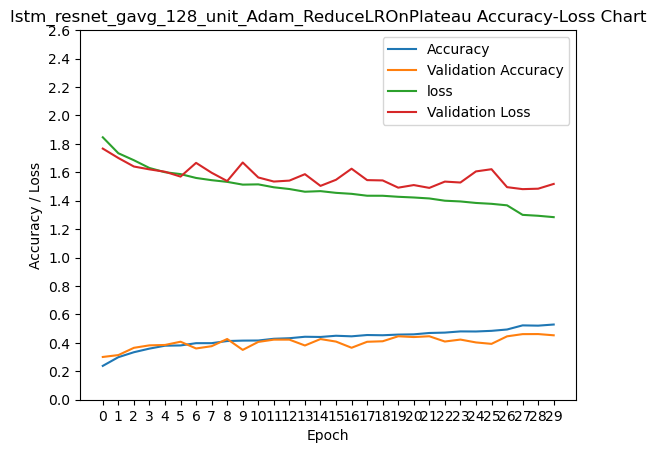

In [78]:
history = model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [80]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('resnet_gavg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 2048)
(678, 7)
170/170 [==============================] - 2s 2ms/step


(678, 7)

In [81]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[29  1  1 32 22 11  2]
 [ 4 45  6 11  0 26  0]
 [ 6  6 27 21 11 18 11]
 [ 8  2 12 29 20 21  6]
 [15  3  6 19 34 10  9]
 [ 6  5  4 21  1 55  4]
 [ 8  0 15 19  9 11 36]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.38      0.30      0.33        98
           1       0.73      0.49      0.58        92
           2       0.38      0.27      0.32       100
           3       0.19      0.30      0.23        98
           4       0.35      0.35      0.35        96
           5       0.36      0.57      0.44        96
           6       0.53      0.37      0.43        98

    accuracy                           0.38       678
   macro avg       0.42      0.38      0.39       678
weighted avg       0.41      0.38      0.38       678



### VGG16_avg

In [83]:
#### Model setup:
Extractor = 'vgg16_avg'
Layer = '128_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '16'

In [84]:
del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_avg')

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8769, 40, 2048)
Shape of y_train:  (8769, 7)
Shape of X_test:  (2191, 40, 2048)
Shape of y_test:  (2191, 7)


In [86]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 1,115,527
Trainable params: 1,115,527
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
547/549 [============================>.] - ETA: 0s - loss: 1.1509 - accuracy: 0.5882
Epoch 1: val_loss improved from inf to 1.03062, saving model to lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 17s 15ms/step - loss: 1.1509 - accuracy: 0.5879 - val_loss: 1.0306 - val_accuracy: 0.6276 - lr: 0.0010
Epoch 2/30
545/549 [============================>.] - ETA: 0s - loss: 0.8823 - accuracy: 0.6945
Epoch 2: val_loss improved from 1.03062 to 0.97363, saving model to lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 7s 12ms/step - loss: 0.8822 - accuracy: 0.6945 - val_loss: 0.9736 - val_accuracy: 0.6486 - lr: 0.0010
Epoch 3/30
547/549 [============================>.] - ETA: 0s - loss: 0.7485 - accuracy: 0.7401
Epoch 3: val_loss improved from 0.97363 to 0.87443, saving model to lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_16_Adam_ReduceLROnPlateau/assets


549/549 [==============================] - 6s 11ms/step - loss: 0.7480 - accuracy: 0.7402 - val_loss: 0.8744 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 4/30
544/549 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.7721
Epoch 4: val_loss did not improve from 0.87443
549/549 [==============================] - 4s 7ms/step - loss: 0.6695 - accuracy: 0.7715 - val_loss: 0.8909 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 5/30
543/549 [============================>.] - ETA: 0s - loss: 0.5885 - accuracy: 0.7958
Epoch 5: val_loss did not improve from 0.87443
549/549 [==============================] - 4s 7ms/step - loss: 0.5900 - accuracy: 0.7954 - val_loss: 0.9031 - val_accuracy: 0.6823 - lr: 0.0010
Epoch 6/30
540/549 [============================>.] - ETA: 0s - loss: 0.5212 - accuracy: 0.8171
Epoch 6: val_loss did not improve from 0.87443
549/549 [==============================] - 4s 7ms/step - loss: 0.5210 - accuracy: 0.8171 - val_loss: 0.8922 - val_accuracy: 0.7065 - lr: 0

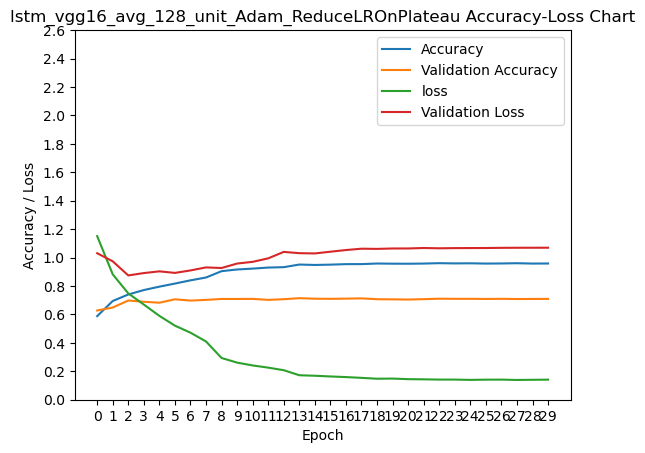

In [87]:
history = model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [89]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_avg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 2048)
(678, 7)
170/170 [==============================] - 4s 2ms/step


(678, 7)

In [90]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[66  2  3 14  1  5  7]
 [ 1 66  7  5  7  4  2]
 [ 9  4 72  1  8  0  6]
 [ 9 11  6 55  4  8  5]
 [ 7  2 11 12 57  2  5]
 [ 0  1  6 19  3 63  4]
 [ 7  2  9  8  7  4 61]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.67      0.67        98
           1       0.75      0.72      0.73        92
           2       0.63      0.72      0.67       100
           3       0.48      0.56      0.52        98
           4       0.66      0.59      0.62        96
           5       0.73      0.66      0.69        96
           6       0.68      0.62      0.65        98

    accuracy                           0.65       678
   macro avg       0.66      0.65      0.65       678
weighted avg       0.66      0.65      0.65       678



### VGG16_gavg

In [92]:
#### Model setup:
Extractor = 'vgg16_gavg'
Layer = '128_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '16'

In [93]:
del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_gavg')

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8768, 40, 512)
Shape of y_train:  (8768, 7)
Shape of X_test:  (2192, 40, 512)
Shape of y_test:  (2192, 7)


In [94]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 512)]         0         
                                                                 
 lstm (LSTM)                 (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 329,095
Trainable params: 329,095
Non-trainable params: 0
_________________________________________________________________


79

Epoch 1/30
541/548 [============================>.] - ETA: 0s - loss: 1.2121 - accuracy: 0.5587
Epoch 1: val_loss improved from inf to 1.17019, saving model to lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


548/548 [==============================] - 24s 10ms/step - loss: 1.2090 - accuracy: 0.5594 - val_loss: 1.1702 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 2/30
544/548 [============================>.] - ETA: 0s - loss: 0.9480 - accuracy: 0.6667
Epoch 2: val_loss improved from 1.17019 to 0.97771, saving model to lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


548/548 [==============================] - 5s 9ms/step - loss: 0.9471 - accuracy: 0.6672 - val_loss: 0.9777 - val_accuracy: 0.6492 - lr: 0.0010
Epoch 3/30
547/548 [============================>.] - ETA: 0s - loss: 0.8290 - accuracy: 0.7070
Epoch 3: val_loss improved from 0.97771 to 0.86261, saving model to lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


548/548 [==============================] - 5s 8ms/step - loss: 0.8291 - accuracy: 0.7072 - val_loss: 0.8626 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 4/30
545/548 [============================>.] - ETA: 0s - loss: 0.7520 - accuracy: 0.7320
Epoch 4: val_loss did not improve from 0.86261
548/548 [==============================] - 2s 4ms/step - loss: 0.7526 - accuracy: 0.7318 - val_loss: 0.9199 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 5/30
542/548 [============================>.] - ETA: 0s - loss: 0.6924 - accuracy: 0.7565
Epoch 5: val_loss improved from 0.86261 to 0.79244, saving model to lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


548/548 [==============================] - 4s 8ms/step - loss: 0.6924 - accuracy: 0.7567 - val_loss: 0.7924 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 6/30
540/548 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.7737
Epoch 6: val_loss did not improve from 0.79244
548/548 [==============================] - 2s 4ms/step - loss: 0.6432 - accuracy: 0.7734 - val_loss: 0.8096 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 7/30
541/548 [============================>.] - ETA: 0s - loss: 0.5892 - accuracy: 0.7919
Epoch 7: val_loss improved from 0.79244 to 0.75520, saving model to lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


548/548 [==============================] - 5s 9ms/step - loss: 0.5883 - accuracy: 0.7923 - val_loss: 0.7552 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 8/30
545/548 [============================>.] - ETA: 0s - loss: 0.5476 - accuracy: 0.8077
Epoch 8: val_loss did not improve from 0.75520
548/548 [==============================] - 2s 4ms/step - loss: 0.5474 - accuracy: 0.8077 - val_loss: 0.8028 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 9/30
544/548 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.8235
Epoch 9: val_loss did not improve from 0.75520
548/548 [==============================] - 2s 4ms/step - loss: 0.5093 - accuracy: 0.8232 - val_loss: 0.7771 - val_accuracy: 0.7395 - lr: 0.0010
Epoch 10/30
536/548 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.8376
Epoch 10: val_loss did not improve from 0.75520
548/548 [==============================] - 2s 4ms/step - loss: 0.4591 - accuracy: 0.8383 - val_loss: 0.7704 - val_accuracy: 0.7422 - lr: 

INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_16_Adam_ReduceLROnPlateau/assets


548/548 [==============================] - 4s 8ms/step - loss: 0.4285 - accuracy: 0.8487 - val_loss: 0.6841 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 12/30
545/548 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.8634
Epoch 12: val_loss did not improve from 0.68413
548/548 [==============================] - 2s 4ms/step - loss: 0.3908 - accuracy: 0.8635 - val_loss: 0.8171 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 13/30
537/548 [============================>.] - ETA: 0s - loss: 0.3616 - accuracy: 0.8747
Epoch 13: val_loss did not improve from 0.68413
548/548 [==============================] - 2s 4ms/step - loss: 0.3615 - accuracy: 0.8748 - val_loss: 0.7854 - val_accuracy: 0.7564 - lr: 0.0010
Epoch 14/30
541/548 [============================>.] - ETA: 0s - loss: 0.3379 - accuracy: 0.8832
Epoch 14: val_loss did not improve from 0.68413
548/548 [==============================] - 2s 4ms/step - loss: 0.3375 - accuracy: 0.8830 - val_loss: 0.7906 - val_accuracy: 0.7614 - 

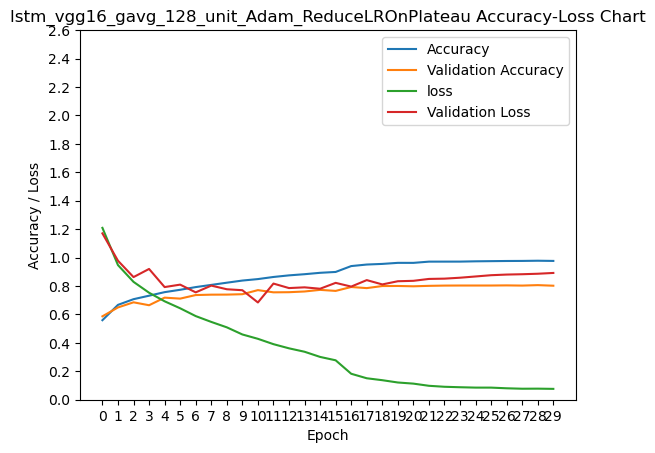

In [95]:
history = model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [96]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_gavg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 512)
(678, 7)
170/170 [==============================] - 1s 2ms/step


(678, 7)

In [97]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[67  0  2 18  2  4  5]
 [ 2 72  5  4  5  3  1]
 [ 9  7 67  3  8  0  6]
 [15  8  3 51  7  8  6]
 [ 3  3  9  8 64  4  5]
 [ 2  7  7 14  6 55  5]
 [ 6  2  9  8  5  3 65]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.68      0.66        98
           1       0.73      0.78      0.75        92
           2       0.66      0.67      0.66       100
           3       0.48      0.52      0.50        98
           4       0.66      0.67      0.66        96
           5       0.71      0.57      0.64        96
           6       0.70      0.66      0.68        98

    accuracy                           0.65       678
   macro avg       0.65      0.65      0.65       678
weighted avg       0.65      0.65      0.65       678



## Setup 3: Adam with weight decay

In [18]:
#### Model setup:
Extractor = 'resnet_gavg'
Layer = '128_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [12]:
#del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('resnet_gavg')
gc.collect()

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8769, 40, 2048)
Shape of y_train:  (8769, 7)
Shape of X_test:  (2191, 40, 2048)
Shape of y_test:  (2191, 7)


0

In [16]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

adam = Adam(decay = 0.001)
mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer=adam ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 1,115,527
Trainable params: 1,115,527
Non-trainable params: 0
_________________________________________________________________


3966

2023-04-18 15:32:56.034065: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2873425920 exceeds 10% of free system memory.
2023-04-18 15:32:58.236971: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2873425920 exceeds 10% of free system memory.


Epoch 1/30


2023-04-18 15:33:24.922508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


2193/2193 [==============================] - ETA: 0s - loss: 1.8237 - accuracy: 0.2518

2023-04-18 15:33:40.473614: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 717946880 exceeds 10% of free system memory.
2023-04-18 15:33:40.970999: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 717946880 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 1.71704, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 45s 6ms/step - loss: 1.8237 - accuracy: 0.2518 - val_loss: 1.7170 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30
2189/2193 [============================>.] - ETA: 0s - loss: 1.6916 - accuracy: 0.3275
Epoch 2: val_loss improved from 1.71704 to 1.65209, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.6916 - accuracy: 0.3275 - val_loss: 1.6521 - val_accuracy: 0.3692 - lr: 0.0010
Epoch 3/30
2193/2193 [==============================] - ETA: 0s - loss: 1.6364 - accuracy: 0.3656
Epoch 3: val_loss improved from 1.65209 to 1.61351, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.6364 - accuracy: 0.3656 - val_loss: 1.6135 - val_accuracy: 0.3802 - lr: 0.0010
Epoch 4/30
2185/2193 [============================>.] - ETA: 0s - loss: 1.6002 - accuracy: 0.3752
Epoch 4: val_loss improved from 1.61351 to 1.60007, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.6008 - accuracy: 0.3751 - val_loss: 1.6001 - val_accuracy: 0.3861 - lr: 0.0010
Epoch 5/30
2190/2193 [============================>.] - ETA: 0s - loss: 1.5602 - accuracy: 0.4014
Epoch 5: val_loss improved from 1.60007 to 1.57471, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.5605 - accuracy: 0.4012 - val_loss: 1.5747 - val_accuracy: 0.4007 - lr: 0.0010
Epoch 6/30
2183/2193 [============================>.] - ETA: 0s - loss: 1.5331 - accuracy: 0.4145
Epoch 6: val_loss improved from 1.57471 to 1.54804, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.5332 - accuracy: 0.4146 - val_loss: 1.5480 - val_accuracy: 0.4131 - lr: 0.0010
Epoch 7/30
2180/2193 [============================>.] - ETA: 0s - loss: 1.5084 - accuracy: 0.4222
Epoch 7: val_loss improved from 1.54804 to 1.53949, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.5082 - accuracy: 0.4218 - val_loss: 1.5395 - val_accuracy: 0.4249 - lr: 0.0010
Epoch 8/30
2182/2193 [============================>.] - ETA: 0s - loss: 1.4897 - accuracy: 0.4317
Epoch 8: val_loss did not improve from 1.53949
2193/2193 [==============================] - 10s 4ms/step - loss: 1.4891 - accuracy: 0.4321 - val_loss: 1.5500 - val_accuracy: 0.4121 - lr: 0.0010
Epoch 9/30
2188/2193 [============================>.] - ETA: 0s - loss: 1.4752 - accuracy: 0.4431
Epoch 9: val_loss did not improve from 1.53949
2193/2193 [==============================] - 9s 4ms/step - loss: 1.4746 - accuracy: 0.4433 - val_loss: 1.5413 - val_accuracy: 0.4131 - lr: 0.0010
Epoch 10/30
2192/2193 [============================>.] - ETA: 0s - loss: 1.4561 - accuracy: 0.4511
Epoch 10: val_loss improved from 1.53949 to 1.53275, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.4562 - accuracy: 0.4510 - val_loss: 1.5328 - val_accuracy: 0.4263 - lr: 0.0010
Epoch 11/30
2191/2193 [============================>.] - ETA: 0s - loss: 1.4449 - accuracy: 0.4548
Epoch 11: val_loss improved from 1.53275 to 1.51528, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.4449 - accuracy: 0.4548 - val_loss: 1.5153 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 12/30
2193/2193 [==============================] - ETA: 0s - loss: 1.4368 - accuracy: 0.4597
Epoch 12: val_loss did not improve from 1.51528
2193/2193 [==============================] - 10s 4ms/step - loss: 1.4368 - accuracy: 0.4597 - val_loss: 1.5216 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 13/30
2189/2193 [============================>.] - ETA: 0s - loss: 1.4259 - accuracy: 0.4624
Epoch 13: val_loss improved from 1.51528 to 1.49545, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.4262 - accuracy: 0.4624 - val_loss: 1.4955 - val_accuracy: 0.4450 - lr: 0.0010
Epoch 14/30
2191/2193 [============================>.] - ETA: 0s - loss: 1.4132 - accuracy: 0.4710
Epoch 14: val_loss did not improve from 1.49545
2193/2193 [==============================] - 9s 4ms/step - loss: 1.4130 - accuracy: 0.4711 - val_loss: 1.5234 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 15/30
2191/2193 [============================>.] - ETA: 0s - loss: 1.4067 - accuracy: 0.4703
Epoch 15: val_loss did not improve from 1.49545
2193/2193 [==============================] - 9s 4ms/step - loss: 1.4066 - accuracy: 0.4704 - val_loss: 1.5393 - val_accuracy: 0.4240 - lr: 0.0010
Epoch 16/30
2192/2193 [============================>.] - ETA: 0s - loss: 1.3906 - accuracy: 0.4810
Epoch 16: val_loss improved from 1.49545 to 1.48409, saving model to lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.3905 - accuracy: 0.4810 - val_loss: 1.4841 - val_accuracy: 0.4523 - lr: 0.0010
Epoch 17/30
2185/2193 [============================>.] - ETA: 0s - loss: 1.3877 - accuracy: 0.4795
Epoch 17: val_loss did not improve from 1.48409
2193/2193 [==============================] - 9s 4ms/step - loss: 1.3869 - accuracy: 0.4800 - val_loss: 1.4954 - val_accuracy: 0.4482 - lr: 0.0010
Epoch 18/30
2179/2193 [============================>.] - ETA: 0s - loss: 1.3722 - accuracy: 0.4845
Epoch 18: val_loss did not improve from 1.48409
2193/2193 [==============================] - 9s 4ms/step - loss: 1.3721 - accuracy: 0.4844 - val_loss: 1.5309 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 19/30
2186/2193 [============================>.] - ETA: 0s - loss: 1.3647 - accuracy: 0.4876
Epoch 19: val_loss did not improve from 1.48409
2193/2193 [==============================] - 9s 4ms/step - loss: 1.3641 - accuracy: 0.4879 - val_loss: 1.5073 - val_accu

INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.3365 - accuracy: 0.5054 - val_loss: 1.4790 - val_accuracy: 0.4610 - lr: 2.0000e-04
Epoch 23/30
2186/2193 [============================>.] - ETA: 0s - loss: 1.3328 - accuracy: 0.5033
Epoch 23: val_loss did not improve from 1.47901
2193/2193 [==============================] - 9s 4ms/step - loss: 1.3332 - accuracy: 0.5034 - val_loss: 1.4959 - val_accuracy: 0.4546 - lr: 2.0000e-04
Epoch 24/30
2190/2193 [============================>.] - ETA: 0s - loss: 1.3253 - accuracy: 0.5102
Epoch 24: val_loss did not improve from 1.47901
2193/2193 [==============================] - 9s 4ms/step - loss: 1.3255 - accuracy: 0.5101 - val_loss: 1.4806 - val_accuracy: 0.4619 - lr: 2.0000e-04
Epoch 25/30
2184/2193 [============================>.] - ETA: 0s - loss: 1.3253 - accuracy: 0.5077
Epoch 25: val_loss did not improve from 1.47901
2193/2193 [==============================] - 9s 4ms/step - loss: 1.3245 - accuracy: 0.5084 - val_loss: 1.488

INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_128_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 1.3249 - accuracy: 0.5075 - val_loss: 1.4783 - val_accuracy: 0.4623 - lr: 4.0000e-05
Epoch 29/30
2180/2193 [============================>.] - ETA: 0s - loss: 1.3176 - accuracy: 0.5102
Epoch 29: val_loss did not improve from 1.47826
2193/2193 [==============================] - 9s 4ms/step - loss: 1.3186 - accuracy: 0.5093 - val_loss: 1.4803 - val_accuracy: 0.4610 - lr: 4.0000e-05
Epoch 30/30
2180/2193 [============================>.] - ETA: 0s - loss: 1.3262 - accuracy: 0.5075
Epoch 30: val_loss did not improve from 1.47826
2193/2193 [==============================] - 9s 4ms/step - loss: 1.3258 - accuracy: 0.5077 - val_loss: 1.4822 - val_accuracy: 0.4587 - lr: 4.0000e-05


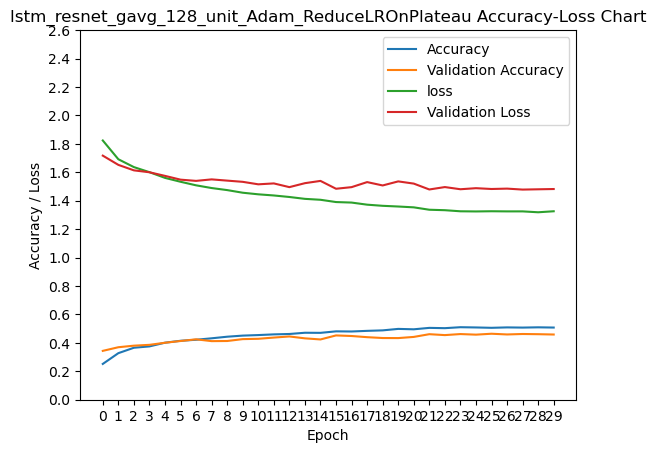

6818

In [17]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
gc.collect()

In [20]:
#del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('resnet_gavg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 2048)
(678, 7)


2023-04-18 15:39:31.815893: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 222167040 exceeds 10% of free system memory.


170/170 [==============================] - 1s 2ms/step


(678, 7)

In [21]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[26  1  5 20 28 15  3]
 [ 3 57 12  7  1 12  0]
 [ 2  8 40  9 19 15  7]
 [ 6  6 14 25 21 22  4]
 [11  4 10 12 36 14  9]
 [ 3  9 13 22  1 46  2]
 [ 8  3 23  9 12 14 29]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.44      0.27      0.33        98
           1       0.65      0.62      0.63        92
           2       0.34      0.40      0.37       100
           3       0.24      0.26      0.25        98
           4       0.31      0.38      0.34        96
           5       0.33      0.48      0.39        96
           6       0.54      0.30      0.38        98

    accuracy                           0.38       678
   macro avg       0.41      0.38      0.38       678
weighted avg       0.40      0.38      0.38       678



### VGG16_avg

In [30]:
#### Model setup:
Extractor = 'vgg16_avg'
Layer = '128_unit'
Optimizer = 'Adam_with_decay'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [31]:
del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_avg')
gc.collect()

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8769, 40, 2048)
Shape of y_train:  (8769, 7)
Shape of X_test:  (2191, 40, 2048)
Shape of y_test:  (2191, 7)


0

In [33]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

adam = Adam(decay = 0.01)
mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer=adam ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 1,115,527
Trainable params: 1,115,527
Non-trainable params: 0
_________________________________________________________________


3948

Epoch 1/30
2193/2193 [==============================] - ETA: 0s - loss: 1.0849 - accuracy: 0.6049
Epoch 1: val_loss improved from inf to 1.03485, saving model to lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2193/2193 [==============================] - 14s 6ms/step - loss: 1.0849 - accuracy: 0.6049 - val_loss: 1.0349 - val_accuracy: 0.6335 - lr: 0.0010
Epoch 2/30
2190/2193 [============================>.] - ETA: 0s - loss: 0.8285 - accuracy: 0.7084
Epoch 2: val_loss improved from 1.03485 to 0.97460, saving model to lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 0.8289 - accuracy: 0.7083 - val_loss: 0.9746 - val_accuracy: 0.6641 - lr: 0.0010
Epoch 3/30
2189/2193 [============================>.] - ETA: 0s - loss: 0.7649 - accuracy: 0.7353
Epoch 3: val_loss improved from 0.97460 to 0.95008, saving model to lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 0.7646 - accuracy: 0.7351 - val_loss: 0.9501 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 4/30
2193/2193 [==============================] - ETA: 0s - loss: 0.7214 - accuracy: 0.7495
Epoch 4: val_loss improved from 0.95008 to 0.94161, saving model to lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 0.7214 - accuracy: 0.7495 - val_loss: 0.9416 - val_accuracy: 0.6728 - lr: 0.0010
Epoch 5/30
2190/2193 [============================>.] - ETA: 0s - loss: 0.7005 - accuracy: 0.7572
Epoch 5: val_loss did not improve from 0.94161
2193/2193 [==============================] - 10s 4ms/step - loss: 0.7005 - accuracy: 0.7571 - val_loss: 0.9534 - val_accuracy: 0.6741 - lr: 0.0010
Epoch 6/30
2183/2193 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.7678
Epoch 6: val_loss did not improve from 0.94161
2193/2193 [==============================] - 9s 4ms/step - loss: 0.6762 - accuracy: 0.7677 - val_loss: 0.9463 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 7/30
2191/2193 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.7713
Epoch 7: val_loss did not improve from 0.94161
2193/2193 [==============================] - 9s 4ms/step - loss: 0.6646 - accuracy: 0.7712 - val_loss: 0.9424 - val_accuracy:

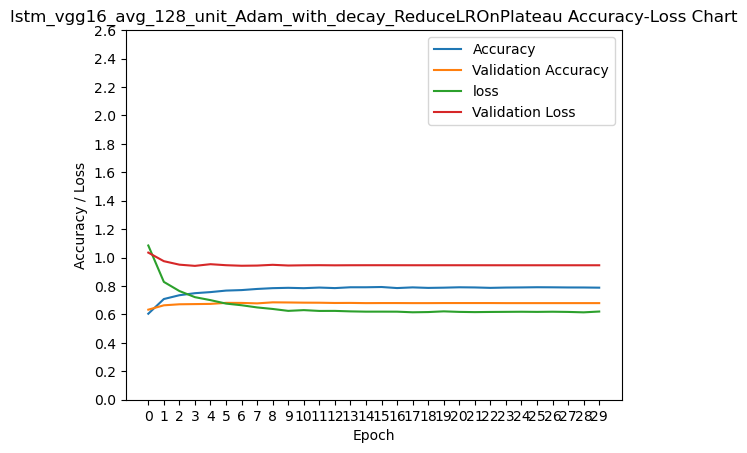

18105

In [34]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
gc.collect()

In [35]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_avg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 2048)
(678, 7)
170/170 [==============================] - 1s 2ms/step


(678, 7)

In [36]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[62  2  2 19  3  5  5]
 [ 3 69  7  8  0  5  0]
 [ 8  5 71  3  6  2  5]
 [12  6 12 53  2  3 10]
 [ 7  4 15 10 51  3  6]
 [ 3  2 10 16  1 61  3]
 [ 8  0  9 10  3  9 59]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.63      0.62        98
           1       0.78      0.75      0.77        92
           2       0.56      0.71      0.63       100
           3       0.45      0.54      0.49        98
           4       0.77      0.53      0.63        96
           5       0.69      0.64      0.66        96
           6       0.67      0.60      0.63        98

    accuracy                           0.63       678
   macro avg       0.65      0.63      0.63       678
weighted avg       0.65      0.63      0.63       678



### VGG16_gavg

In [25]:
#### Model setup:
Extractor = 'vgg16_gavg'
Layer = '128_unit'
Optimizer = 'Adam_with_decay'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [24]:
del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_gavg')
gc.collect()

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8768, 40, 512)
Shape of y_train:  (8768, 7)
Shape of X_test:  (2192, 40, 512)
Shape of y_test:  (2192, 7)


0

In [26]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(128, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

adam = Adam(decay = 0.01)
mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer=adam ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 512)]         0         
                                                                 
 lstm (LSTM)                 (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 329,095
Trainable params: 329,095
Non-trainable params: 0
_________________________________________________________________


228

Epoch 1/30
2180/2192 [============================>.] - ETA: 0s - loss: 1.1522 - accuracy: 0.5835
Epoch 1: val_loss improved from inf to 1.04646, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 1.1521 - accuracy: 0.5833 - val_loss: 1.0465 - val_accuracy: 0.6268 - lr: 0.0010
Epoch 2/30
2175/2192 [============================>.] - ETA: 0s - loss: 0.9345 - accuracy: 0.6678
Epoch 2: val_loss improved from 1.04646 to 1.02223, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.9346 - accuracy: 0.6679 - val_loss: 1.0222 - val_accuracy: 0.6382 - lr: 0.0010
Epoch 3/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.8836 - accuracy: 0.6877
Epoch 3: val_loss did not improve from 1.02223
2192/2192 [==============================] - 7s 3ms/step - loss: 0.8838 - accuracy: 0.6877 - val_loss: 1.0312 - val_accuracy: 0.6401 - lr: 0.0010
Epoch 4/30
2189/2192 [============================>.] - ETA: 0s - loss: 0.8631 - accuracy: 0.6945
Epoch 4: val_loss improved from 1.02223 to 1.01383, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.8632 - accuracy: 0.6946 - val_loss: 1.0138 - val_accuracy: 0.6451 - lr: 0.0010
Epoch 5/30
2189/2192 [============================>.] - ETA: 0s - loss: 0.8435 - accuracy: 0.7007
Epoch 5: val_loss improved from 1.01383 to 1.00109, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.8439 - accuracy: 0.7004 - val_loss: 1.0011 - val_accuracy: 0.6537 - lr: 0.0010
Epoch 6/30
2173/2192 [============================>.] - ETA: 0s - loss: 0.8290 - accuracy: 0.7130
Epoch 6: val_loss did not improve from 1.00109
2192/2192 [==============================] - 7s 3ms/step - loss: 0.8293 - accuracy: 0.7128 - val_loss: 1.0136 - val_accuracy: 0.6478 - lr: 0.0010
Epoch 7/30
2180/2192 [============================>.] - ETA: 0s - loss: 0.8162 - accuracy: 0.7162
Epoch 7: val_loss improved from 1.00109 to 0.99963, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.8165 - accuracy: 0.7159 - val_loss: 0.9996 - val_accuracy: 0.6542 - lr: 0.0010
Epoch 8/30
2177/2192 [============================>.] - ETA: 0s - loss: 0.8100 - accuracy: 0.7149
Epoch 8: val_loss did not improve from 0.99963
2192/2192 [==============================] - 7s 3ms/step - loss: 0.8105 - accuracy: 0.7144 - val_loss: 0.9997 - val_accuracy: 0.6537 - lr: 0.0010
Epoch 9/30
2188/2192 [============================>.] - ETA: 0s - loss: 0.8003 - accuracy: 0.7226
Epoch 9: val_loss did not improve from 0.99963
2192/2192 [==============================] - 7s 3ms/step - loss: 0.8003 - accuracy: 0.7225 - val_loss: 1.0048 - val_accuracy: 0.6519 - lr: 0.0010
Epoch 10/30
2188/2192 [============================>.] - ETA: 0s - loss: 0.8030 - accuracy: 0.7195
Epoch 10: val_loss improved from 0.99963 to 0.99690, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.8028 - accuracy: 0.7197 - val_loss: 0.9969 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 11/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.7977 - accuracy: 0.7213
Epoch 11: val_loss improved from 0.99690 to 0.99555, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.7974 - accuracy: 0.7213 - val_loss: 0.9956 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 12/30
2189/2192 [============================>.] - ETA: 0s - loss: 0.7864 - accuracy: 0.7237
Epoch 12: val_loss improved from 0.99555 to 0.99470, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.7866 - accuracy: 0.7235 - val_loss: 0.9947 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 13/30
2190/2192 [============================>.] - ETA: 0s - loss: 0.7820 - accuracy: 0.7272
Epoch 13: val_loss did not improve from 0.99470
2192/2192 [==============================] - 7s 3ms/step - loss: 0.7825 - accuracy: 0.7271 - val_loss: 1.0007 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 14/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.7767 - accuracy: 0.7271
Epoch 14: val_loss improved from 0.99470 to 0.99260, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.7763 - accuracy: 0.7274 - val_loss: 0.9926 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 15/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.7757 - accuracy: 0.7341
Epoch 15: val_loss improved from 0.99260 to 0.99253, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.7749 - accuracy: 0.7346 - val_loss: 0.9925 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 16/30
2191/2192 [============================>.] - ETA: 0s - loss: 0.7743 - accuracy: 0.7241
Epoch 16: val_loss did not improve from 0.99253
2192/2192 [==============================] - 7s 3ms/step - loss: 0.7744 - accuracy: 0.7241 - val_loss: 0.9949 - val_accuracy: 0.6542 - lr: 0.0010
Epoch 17/30
2191/2192 [============================>.] - ETA: 0s - loss: 0.7697 - accuracy: 0.7324
Epoch 17: val_loss did not improve from 0.99253
2192/2192 [==============================] - 7s 3ms/step - loss: 0.7697 - accuracy: 0.7323 - val_loss: 1.0039 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 18/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.7625 - accuracy: 0.7366
Epoch 18: val_loss improved from 0.99253 to 0.98720, saving model to lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_128_unit_4_Adam_with_decay_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.7636 - accuracy: 0.7364 - val_loss: 0.9872 - val_accuracy: 0.6601 - lr: 0.0010
Epoch 19/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.7666 - accuracy: 0.7351
Epoch 19: val_loss did not improve from 0.98720
2192/2192 [==============================] - 7s 3ms/step - loss: 0.7671 - accuracy: 0.7348 - val_loss: 1.0008 - val_accuracy: 0.6519 - lr: 0.0010
Epoch 20/30
2192/2192 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.7393
Epoch 20: val_loss did not improve from 0.98720
2192/2192 [==============================] - 7s 3ms/step - loss: 0.7587 - accuracy: 0.7393 - val_loss: 0.9910 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 21/30
2187/2192 [============================>.] - ETA: 0s - loss: 0.7548 - accuracy: 0.7350
Epoch 21: val_loss did not improve from 0.98720
2192/2192 [==============================] - 7s 3ms/step - loss: 0.7554 - accuracy: 0.7348 - val_loss: 0.9892 - val_accur

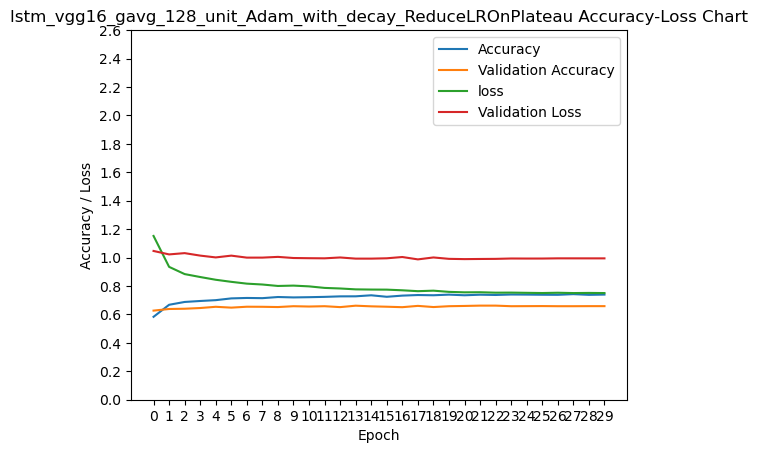

21091

In [27]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
gc.collect()

In [28]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_gavg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 512)
(678, 7)
170/170 [==============================] - 1s 1ms/step


(678, 7)

In [29]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[79  1  2 13  1  0  2]
 [ 7 65  8  9  0  1  2]
 [ 9  7 72  3  3  0  6]
 [16  4  8 62  3  0  5]
 [18  5 15  8 38  0 12]
 [13  3 12 28  2 35  3]
 [12  0  8 12  1  4 61]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.81      0.63        98
           1       0.76      0.71      0.73        92
           2       0.58      0.72      0.64       100
           3       0.46      0.63      0.53        98
           4       0.79      0.40      0.53        96
           5       0.88      0.36      0.51        96
           6       0.67      0.62      0.65        98

    accuracy                           0.61       678
   macro avg       0.66      0.61      0.60       678
weighted avg       0.66      0.61      0.60       678



## Setup 4: LSTM unit 10

### Resnet_gavg

In [11]:
#### Model setup:
Extractor = 'resnet_gavg'
Layer = '10_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [13]:
#del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('resnet_gavg')

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8769, 40, 2048)
Shape of y_train:  (8769, 7)
Shape of X_test:  (2191, 40, 2048)
Shape of y_test:  (2191, 7)


In [16]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(10, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 10)                82360     
                                                                 
 dense (Dense)               (None, 7)                 77        
                                                                 
Total params: 82,437
Trainable params: 82,437
Non-trainable params: 0
_________________________________________________________________


0

2023-04-18 14:17:35.997639: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2873425920 exceeds 10% of free system memory.
2023-04-18 14:17:38.060782: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2873425920 exceeds 10% of free system memory.


Epoch 1/30


2023-04-18 14:18:04.634226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-18 14:18:09.438610: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe738139aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-18 14:18:09.438634: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce GTX 1080, Compute Capability 6.1
2023-04-18 14:18:10.340722: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-18 14:18:16.252059: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often

  29/2193 [..............................] - ETA: 8s - loss: 1.9701 - accuracy: 0.1724    

2023-04-18 14:18:17.270479: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-18 14:18:17.270549: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-18 14:18:17.277652: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

2193/2193 [==============================] - ETA: 0s - loss: 1.9237 - accuracy: 0.1846

2023-04-18 14:18:25.551468: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 717946880 exceeds 10% of free system memory.
2023-04-18 14:18:26.056003: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 717946880 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 1.92166, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 50s 6ms/step - loss: 1.9237 - accuracy: 0.1846 - val_loss: 1.9217 - val_accuracy: 0.1780 - lr: 0.0010
Epoch 2/30
2190/2193 [============================>.] - ETA: 0s - loss: 1.8207 - accuracy: 0.2674
Epoch 2: val_loss improved from 1.92166 to 1.78012, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 11s 5ms/step - loss: 1.8205 - accuracy: 0.2673 - val_loss: 1.7801 - val_accuracy: 0.2748 - lr: 0.0010
Epoch 3/30
2184/2193 [============================>.] - ETA: 0s - loss: 1.7460 - accuracy: 0.3085
Epoch 3: val_loss improved from 1.78012 to 1.75795, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.7456 - accuracy: 0.3088 - val_loss: 1.7580 - val_accuracy: 0.2880 - lr: 0.0010
Epoch 4/30
2185/2193 [============================>.] - ETA: 0s - loss: 1.7054 - accuracy: 0.3276
Epoch 4: val_loss improved from 1.75795 to 1.68438, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 11s 5ms/step - loss: 1.7059 - accuracy: 0.3273 - val_loss: 1.6844 - val_accuracy: 0.3450 - lr: 0.0010
Epoch 5/30
2189/2193 [============================>.] - ETA: 0s - loss: 1.6839 - accuracy: 0.3415
Epoch 5: val_loss improved from 1.68438 to 1.67149, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.6840 - accuracy: 0.3412 - val_loss: 1.6715 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 6/30
2188/2193 [============================>.] - ETA: 0s - loss: 1.6635 - accuracy: 0.3486
Epoch 6: val_loss improved from 1.67149 to 1.65098, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 11s 5ms/step - loss: 1.6633 - accuracy: 0.3487 - val_loss: 1.6510 - val_accuracy: 0.3578 - lr: 0.0010
Epoch 7/30
2181/2193 [============================>.] - ETA: 0s - loss: 1.6507 - accuracy: 0.3599
Epoch 7: val_loss did not improve from 1.65098
2193/2193 [==============================] - 9s 4ms/step - loss: 1.6507 - accuracy: 0.3601 - val_loss: 1.6532 - val_accuracy: 0.3574 - lr: 0.0010
Epoch 8/30
2190/2193 [============================>.] - ETA: 0s - loss: 1.6326 - accuracy: 0.3656
Epoch 8: val_loss improved from 1.65098 to 1.62896, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.6327 - accuracy: 0.3658 - val_loss: 1.6290 - val_accuracy: 0.3724 - lr: 0.0010
Epoch 9/30
2185/2193 [============================>.] - ETA: 0s - loss: 1.6220 - accuracy: 0.3721
Epoch 9: val_loss improved from 1.62896 to 1.61521, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 11s 5ms/step - loss: 1.6219 - accuracy: 0.3722 - val_loss: 1.6152 - val_accuracy: 0.3806 - lr: 0.0010
Epoch 10/30
2183/2193 [============================>.] - ETA: 0s - loss: 1.6138 - accuracy: 0.3733
Epoch 10: val_loss improved from 1.61521 to 1.61283, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.6139 - accuracy: 0.3736 - val_loss: 1.6128 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 11/30
2184/2193 [============================>.] - ETA: 0s - loss: 1.6081 - accuracy: 0.3800
Epoch 11: val_loss did not improve from 1.61283
2193/2193 [==============================] - 9s 4ms/step - loss: 1.6080 - accuracy: 0.3799 - val_loss: 1.6494 - val_accuracy: 0.3537 - lr: 0.0010
Epoch 12/30
2180/2193 [============================>.] - ETA: 0s - loss: 1.5937 - accuracy: 0.3780
Epoch 12: val_loss improved from 1.61283 to 1.58681, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.5939 - accuracy: 0.3776 - val_loss: 1.5868 - val_accuracy: 0.4035 - lr: 0.0010
Epoch 13/30
2180/2193 [============================>.] - ETA: 0s - loss: 1.5781 - accuracy: 0.3944
Epoch 13: val_loss improved from 1.58681 to 1.57851, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 11s 5ms/step - loss: 1.5788 - accuracy: 0.3935 - val_loss: 1.5785 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 14/30
2181/2193 [============================>.] - ETA: 0s - loss: 1.5780 - accuracy: 0.3862
Epoch 14: val_loss did not improve from 1.57851
2193/2193 [==============================] - 9s 4ms/step - loss: 1.5769 - accuracy: 0.3866 - val_loss: 1.6191 - val_accuracy: 0.3724 - lr: 0.0010
Epoch 15/30
2193/2193 [==============================] - ETA: 0s - loss: 1.5661 - accuracy: 0.3982
Epoch 15: val_loss did not improve from 1.57851
2193/2193 [==============================] - 9s 4ms/step - loss: 1.5661 - accuracy: 0.3982 - val_loss: 1.6004 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 16/30
2188/2193 [============================>.] - ETA: 0s - loss: 1.5565 - accuracy: 0.4024
Epoch 16: val_loss did not improve from 1.57851
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5560 - accuracy: 0.4027 - val_loss: 1.6219 - val_acc

INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.5475 - accuracy: 0.4076 - val_loss: 1.5591 - val_accuracy: 0.4131 - lr: 0.0010
Epoch 19/30
2190/2193 [============================>.] - ETA: 0s - loss: 1.5438 - accuracy: 0.4142
Epoch 19: val_loss did not improve from 1.55914
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5442 - accuracy: 0.4142 - val_loss: 1.5618 - val_accuracy: 0.4048 - lr: 0.0010
Epoch 20/30
2181/2193 [============================>.] - ETA: 0s - loss: 1.5353 - accuracy: 0.4107
Epoch 20: val_loss did not improve from 1.55914
2193/2193 [==============================] - 9s 4ms/step - loss: 1.5355 - accuracy: 0.4107 - val_loss: 1.5817 - val_accuracy: 0.3962 - lr: 0.0010
Epoch 21/30
2193/2193 [==============================] - ETA: 0s - loss: 1.5290 - accuracy: 0.4160
Epoch 21: val_loss improved from 1.55914 to 1.55357, saving model to lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.5290 - accuracy: 0.4160 - val_loss: 1.5536 - val_accuracy: 0.4108 - lr: 0.0010
Epoch 22/30
2191/2193 [============================>.] - ETA: 0s - loss: 1.5229 - accuracy: 0.4174
Epoch 22: val_loss did not improve from 1.55357
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5230 - accuracy: 0.4173 - val_loss: 1.6530 - val_accuracy: 0.3647 - lr: 0.0010
Epoch 23/30
2182/2193 [============================>.] - ETA: 0s - loss: 1.5225 - accuracy: 0.4199
Epoch 23: val_loss did not improve from 1.55357
2193/2193 [==============================] - 9s 4ms/step - loss: 1.5231 - accuracy: 0.4201 - val_loss: 1.6104 - val_accuracy: 0.4003 - lr: 0.0010
Epoch 24/30
2191/2193 [============================>.] - ETA: 0s - loss: 1.5156 - accuracy: 0.4205
Epoch 24: val_loss did not improve from 1.55357
2193/2193 [==============================] - 9s 4ms/step - loss: 1.5154 - accuracy: 0.4207 - val_loss: 1.6106 - val_acc

INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_resnet_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.5184 - accuracy: 0.4219 - val_loss: 1.5515 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 26/30
2184/2193 [============================>.] - ETA: 0s - loss: 1.5123 - accuracy: 0.4233
Epoch 26: val_loss did not improve from 1.55151
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5124 - accuracy: 0.4234 - val_loss: 1.5759 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 27/30
2188/2193 [============================>.] - ETA: 0s - loss: 1.5030 - accuracy: 0.4237
Epoch 27: val_loss did not improve from 1.55151
2193/2193 [==============================] - 10s 4ms/step - loss: 1.5031 - accuracy: 0.4233 - val_loss: 1.5560 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 28/30
2186/2193 [============================>.] - ETA: 0s - loss: 1.4994 - accuracy: 0.4265
Epoch 28: val_loss did not improve from 1.55151
2193/2193 [==============================] - 10s 4ms/step - loss: 1.4987 - accuracy: 0.4270 - val_loss: 1.6126 - val_a

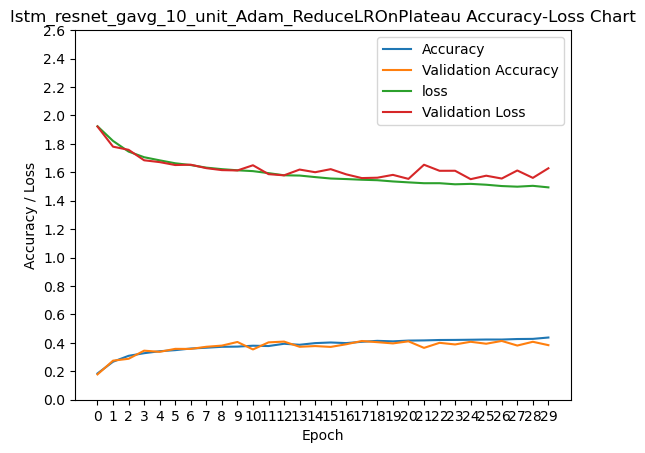

In [17]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [19]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('resnet_gavg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 2048)
(678, 7)
170/170 [==============================] - 1s 2ms/step


(678, 7)

In [20]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[19  7  7 29 33  1  2]
 [ 2 72  7  9  1  1  0]
 [ 3 39 23  9 24  0  2]
 [ 5 26 16 25 20  3  3]
 [ 7 11 16 17 42  0  3]
 [ 4 40  5 34  7  6  0]
 [ 6 12 33 14 15  2 16]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.41      0.19      0.26        98
           1       0.35      0.78      0.48        92
           2       0.21      0.23      0.22       100
           3       0.18      0.26      0.21        98
           4       0.30      0.44      0.35        96
           5       0.46      0.06      0.11        96
           6       0.62      0.16      0.26        98

    accuracy                           0.30       678
   macro avg       0.36      0.30      0.27       678
weighted avg       0.36      0.30      0.27       678



### VGG16_avg

In [21]:
#### Model setup:
Extractor = 'vgg16_avg'
Layer = '10_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [22]:
del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_avg')
gc.collect()

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8769, 40, 2048)
Shape of y_train:  (8769, 7)
Shape of X_test:  (2191, 40, 2048)
Shape of y_test:  (2191, 7)


0

In [24]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(10, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 10)                82360     
                                                                 
 dense (Dense)               (None, 7)                 77        
                                                                 
Total params: 82,437
Trainable params: 82,437
Non-trainable params: 0
_________________________________________________________________


3948

2023-04-18 14:27:48.170681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2873425920 exceeds 10% of free system memory.


Epoch 1/30
2186/2193 [============================>.] - ETA: 0s - loss: 1.4006 - accuracy: 0.5133
Epoch 1: val_loss improved from inf to 1.21263, saving model to lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 16s 6ms/step - loss: 1.3998 - accuracy: 0.5136 - val_loss: 1.2126 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 2/30
2181/2193 [============================>.] - ETA: 0s - loss: 1.0341 - accuracy: 0.6522
Epoch 2: val_loss improved from 1.21263 to 1.07896, saving model to lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 1.0337 - accuracy: 0.6523 - val_loss: 1.0790 - val_accuracy: 0.6194 - lr: 0.0010
Epoch 3/30
2185/2193 [============================>.] - ETA: 0s - loss: 0.8892 - accuracy: 0.6998
Epoch 3: val_loss improved from 1.07896 to 1.05740, saving model to lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 0.8893 - accuracy: 0.6997 - val_loss: 1.0574 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 4/30
2193/2193 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.7200
Epoch 4: val_loss improved from 1.05740 to 1.01075, saving model to lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 0.8157 - accuracy: 0.7200 - val_loss: 1.0108 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 5/30
2186/2193 [============================>.] - ETA: 0s - loss: 0.7720 - accuracy: 0.7339
Epoch 5: val_loss improved from 1.01075 to 0.98346, saving model to lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 0.7707 - accuracy: 0.7346 - val_loss: 0.9835 - val_accuracy: 0.6577 - lr: 0.0010
Epoch 6/30
2185/2193 [============================>.] - ETA: 0s - loss: 0.7131 - accuracy: 0.7555
Epoch 6: val_loss did not improve from 0.98346
2193/2193 [==============================] - 10s 4ms/step - loss: 0.7125 - accuracy: 0.7558 - val_loss: 1.0053 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 7/30
2191/2193 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.7664
Epoch 7: val_loss did not improve from 0.98346
2193/2193 [==============================] - 10s 4ms/step - loss: 0.6772 - accuracy: 0.7663 - val_loss: 1.0122 - val_accuracy: 0.6499 - lr: 0.0010
Epoch 8/30
2182/2193 [============================>.] - ETA: 0s - loss: 0.6355 - accuracy: 0.7796
Epoch 8: val_loss did not improve from 0.98346
2193/2193 [==============================] - 10s 4ms/step - loss: 0.6347 - accuracy: 0.7799 - val_loss: 1.0580 - val_accurac

INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 5ms/step - loss: 0.5032 - accuracy: 0.8261 - val_loss: 0.9815 - val_accuracy: 0.6718 - lr: 2.0000e-04
Epoch 12/30
2184/2193 [============================>.] - ETA: 0s - loss: 0.4828 - accuracy: 0.8405
Epoch 12: val_loss improved from 0.98149 to 0.98118, saving model to lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_avg_10_unit_4_Adam_ReduceLROnPlateau/assets


2193/2193 [==============================] - 12s 6ms/step - loss: 0.4831 - accuracy: 0.8405 - val_loss: 0.9812 - val_accuracy: 0.6755 - lr: 2.0000e-04
Epoch 13/30
2193/2193 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.8402
Epoch 13: val_loss did not improve from 0.98118
2193/2193 [==============================] - 10s 4ms/step - loss: 0.4699 - accuracy: 0.8402 - val_loss: 0.9871 - val_accuracy: 0.6769 - lr: 2.0000e-04
Epoch 14/30
2191/2193 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.8442
Epoch 14: val_loss did not improve from 0.98118
2193/2193 [==============================] - 10s 4ms/step - loss: 0.4581 - accuracy: 0.8442 - val_loss: 0.9926 - val_accuracy: 0.6728 - lr: 2.0000e-04
Epoch 15/30
2188/2193 [============================>.] - ETA: 0s - loss: 0.4478 - accuracy: 0.8487
Epoch 15: val_loss did not improve from 0.98118
2193/2193 [==============================] - 10s 4ms/step - loss: 0.4475 - accuracy: 0.8488 - val_loss: 0.

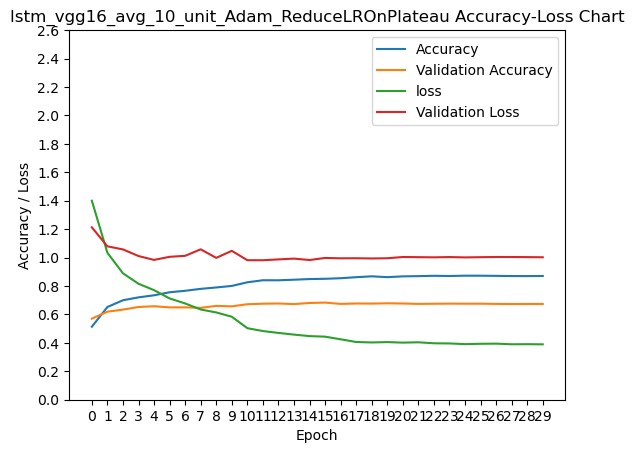

21553

In [25]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
gc.collect()

In [26]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_avg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 2048)
(678, 7)
170/170 [==============================] - 1s 2ms/step


(678, 7)

In [27]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[61  0  2 23  5  3  4]
 [ 0 64  8 11  5  3  1]
 [ 7  5 70  2 14  0  2]
 [ 8  5  8 61  3  7  6]
 [ 6  5 12 13 55  2  3]
 [ 2  6  6 31  5 44  2]
 [ 7  1  7 14  6  6 57]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.62      0.65        98
           1       0.74      0.70      0.72        92
           2       0.62      0.70      0.66       100
           3       0.39      0.62      0.48        98
           4       0.59      0.57      0.58        96
           5       0.68      0.46      0.55        96
           6       0.76      0.58      0.66        98

    accuracy                           0.61       678
   macro avg       0.64      0.61      0.61       678
weighted avg       0.64      0.61      0.61       678



### VGG16_gavg

In [28]:
#### Model setup:
Extractor = 'vgg16_gavg'
Layer = '10_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [29]:
del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_gavg')
gc.collect()

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8768, 40, 512)
Shape of y_train:  (8768, 7)
Shape of X_test:  (2192, 40, 512)
Shape of y_test:  (2192, 7)


0

In [30]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm = LSTM(10, return_sequences=False, dropout=0.5)(inputs)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 512)]         0         
                                                                 
 lstm (LSTM)                 (None, 10)                20920     
                                                                 
 dense (Dense)               (None, 7)                 77        
                                                                 
Total params: 20,997
Trainable params: 20,997
Non-trainable params: 0
_________________________________________________________________


79

Epoch 1/30
2175/2192 [============================>.] - ETA: 0s - loss: 1.3786 - accuracy: 0.4961
Epoch 1: val_loss improved from inf to 1.10682, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 13s 5ms/step - loss: 1.3754 - accuracy: 0.4973 - val_loss: 1.1068 - val_accuracy: 0.6191 - lr: 0.0010
Epoch 2/30
2187/2192 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.6626
Epoch 2: val_loss improved from 1.10682 to 0.96288, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 5ms/step - loss: 0.9876 - accuracy: 0.6623 - val_loss: 0.9629 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 3/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.8779 - accuracy: 0.6965
Epoch 3: val_loss did not improve from 0.96288
2192/2192 [==============================] - 7s 3ms/step - loss: 0.8785 - accuracy: 0.6963 - val_loss: 0.9723 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 4/30
2178/2192 [============================>.] - ETA: 0s - loss: 0.8067 - accuracy: 0.7221
Epoch 4: val_loss improved from 0.96288 to 0.88050, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.8073 - accuracy: 0.7222 - val_loss: 0.8805 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 5/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.7670 - accuracy: 0.7330
Epoch 5: val_loss improved from 0.88050 to 0.85204, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.7672 - accuracy: 0.7327 - val_loss: 0.8520 - val_accuracy: 0.6998 - lr: 0.0010
Epoch 6/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.7235 - accuracy: 0.7483
Epoch 6: val_loss improved from 0.85204 to 0.83939, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.7225 - accuracy: 0.7487 - val_loss: 0.8394 - val_accuracy: 0.7012 - lr: 0.0010
Epoch 7/30
2180/2192 [============================>.] - ETA: 0s - loss: 0.7077 - accuracy: 0.7497
Epoch 7: val_loss improved from 0.83939 to 0.80635, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.7084 - accuracy: 0.7492 - val_loss: 0.8063 - val_accuracy: 0.7144 - lr: 0.0010
Epoch 8/30
2178/2192 [============================>.] - ETA: 0s - loss: 0.6787 - accuracy: 0.7661
Epoch 8: val_loss did not improve from 0.80635
2192/2192 [==============================] - 7s 3ms/step - loss: 0.6782 - accuracy: 0.7662 - val_loss: 0.8718 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 9/30
2177/2192 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.7694
Epoch 9: val_loss did not improve from 0.80635
2192/2192 [==============================] - 7s 3ms/step - loss: 0.6609 - accuracy: 0.7700 - val_loss: 0.8925 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 10/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.7799
Epoch 10: val_loss improved from 0.80635 to 0.80222, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.6381 - accuracy: 0.7800 - val_loss: 0.8022 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 11/30
2183/2192 [============================>.] - ETA: 0s - loss: 0.6200 - accuracy: 0.7844
Epoch 11: val_loss improved from 0.80222 to 0.79459, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 9s 4ms/step - loss: 0.6197 - accuracy: 0.7846 - val_loss: 0.7946 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 12/30
2192/2192 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.7846
Epoch 12: val_loss improved from 0.79459 to 0.79340, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 5ms/step - loss: 0.6158 - accuracy: 0.7846 - val_loss: 0.7934 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 13/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.5922 - accuracy: 0.7939
Epoch 13: val_loss did not improve from 0.79340
2192/2192 [==============================] - 8s 3ms/step - loss: 0.5923 - accuracy: 0.7937 - val_loss: 0.8011 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 14/30
2188/2192 [============================>.] - ETA: 0s - loss: 0.5823 - accuracy: 0.7965
Epoch 14: val_loss did not improve from 0.79340
2192/2192 [==============================] - 7s 3ms/step - loss: 0.5825 - accuracy: 0.7962 - val_loss: 0.8320 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 15/30
2177/2192 [============================>.] - ETA: 0s - loss: 0.5671 - accuracy: 0.8021
Epoch 15: val_loss did not improve from 0.79340
2192/2192 [==============================] - 8s 3ms/step - loss: 0.5677 - accuracy: 0.8021 - val_loss: 0.8274 - val_accu

INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 5ms/step - loss: 0.4860 - accuracy: 0.8303 - val_loss: 0.7896 - val_accuracy: 0.7349 - lr: 2.0000e-04
Epoch 19/30
2188/2192 [============================>.] - ETA: 0s - loss: 0.4654 - accuracy: 0.8391
Epoch 19: val_loss did not improve from 0.78959
2192/2192 [==============================] - 8s 4ms/step - loss: 0.4657 - accuracy: 0.8391 - val_loss: 0.7972 - val_accuracy: 0.7286 - lr: 2.0000e-04
Epoch 20/30
2180/2192 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.8461
Epoch 20: val_loss improved from 0.78959 to 0.78838, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 5ms/step - loss: 0.4598 - accuracy: 0.8459 - val_loss: 0.7884 - val_accuracy: 0.7432 - lr: 2.0000e-04
Epoch 21/30
2189/2192 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.8452
Epoch 21: val_loss improved from 0.78838 to 0.78262, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 5ms/step - loss: 0.4531 - accuracy: 0.8453 - val_loss: 0.7826 - val_accuracy: 0.7409 - lr: 2.0000e-04
Epoch 22/30
2192/2192 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.8459
Epoch 22: val_loss did not improve from 0.78262
2192/2192 [==============================] - 8s 4ms/step - loss: 0.4520 - accuracy: 0.8459 - val_loss: 0.8044 - val_accuracy: 0.7368 - lr: 2.0000e-04
Epoch 23/30
2191/2192 [============================>.] - ETA: 0s - loss: 0.4557 - accuracy: 0.8416
Epoch 23: val_loss did not improve from 0.78262
2192/2192 [==============================] - 8s 3ms/step - loss: 0.4559 - accuracy: 0.8415 - val_loss: 0.7842 - val_accuracy: 0.7464 - lr: 2.0000e-04
Epoch 24/30
2178/2192 [============================>.] - ETA: 0s - loss: 0.4428 - accuracy: 0.8476
Epoch 24: val_loss improved from 0.78262 to 0.77863, saving model to lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_10_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 10s 4ms/step - loss: 0.4420 - accuracy: 0.8480 - val_loss: 0.7786 - val_accuracy: 0.7413 - lr: 2.0000e-04
Epoch 25/30
2179/2192 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.8511
Epoch 25: val_loss did not improve from 0.77863
2192/2192 [==============================] - 8s 3ms/step - loss: 0.4346 - accuracy: 0.8514 - val_loss: 0.8178 - val_accuracy: 0.7436 - lr: 2.0000e-04
Epoch 26/30
2190/2192 [============================>.] - ETA: 0s - loss: 0.4392 - accuracy: 0.8493
Epoch 26: val_loss did not improve from 0.77863
2192/2192 [==============================] - 7s 3ms/step - loss: 0.4390 - accuracy: 0.8495 - val_loss: 0.7985 - val_accuracy: 0.7418 - lr: 2.0000e-04
Epoch 27/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.4335 - accuracy: 0.8484
Epoch 27: val_loss did not improve from 0.77863
2192/2192 [==============================] - 7s 3ms/step - loss: 0.4328 - accuracy: 0.8487 - val_loss: 0.810

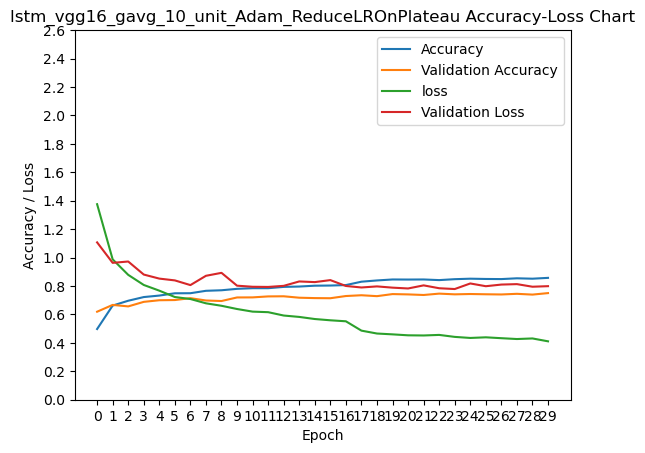

21553

In [31]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
gc.collect()

In [34]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_gavg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 512)
(678, 7)
170/170 [==============================] - 0s 2ms/step


(678, 7)

In [35]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[61  0  0 18  4  8  7]
 [ 5 71  1  7  3  4  1]
 [ 6 11 66  1 13  0  3]
 [11  9  4 60  3  6  5]
 [10  1  7 10 59  4  5]
 [ 1  2  7 18  4 62  2]
 [ 7  0  8  5 10  4 64]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.62      0.61        98
           1       0.76      0.77      0.76        92
           2       0.71      0.66      0.68       100
           3       0.50      0.61      0.55        98
           4       0.61      0.61      0.61        96
           5       0.70      0.65      0.67        96
           6       0.74      0.65      0.69        98

    accuracy                           0.65       678
   macro avg       0.66      0.65      0.66       678
weighted avg       0.66      0.65      0.66       678



## Setup 5: 2 Layer LSTM

### VGG16_gavg

In [37]:
#### Model setup:
Extractor = 'vgg16_gavg'
Layer = '2_layer_128_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [38]:
del X_train, y_train, X_test, y_test
gc.collect()
X_train, y_train, X_test, y_test = read_dataset_40f('vgg16_gavg')
gc.collect()

Loaded X_train
Loaded y_train
Loaded X_test
Loaded y_test
Shape of X_train:  (8768, 40, 512)
Shape of y_train:  (8768, 7)
Shape of X_test:  (2192, 40, 512)
Shape of y_test:  (2192, 7)


0

In [40]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm1 = LSTM(128, return_sequences=True, dropout=0.5)(inputs)

lstm12 = LSTM(64, return_sequences=False, dropout=0.5)(lstm1)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm12)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 512)]         0         
                                                                 
 lstm (LSTM)                 (None, 40, 128)           328192    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 378,055
Trainable params: 378,055
Non-trainable params: 0
_________________________________________________________________


463

Epoch 1/30


2023-04-18 16:08:55.777980: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f789e69d930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-18 16:08:55.803738: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce GTX 1080, Compute Capability 6.1
2023-04-18 16:08:57.679408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-18 16:09:05.347601: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-18 16:09:05.347714: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNIN

  38/2192 [..............................] - ETA: 8s - loss: 1.9473 - accuracy: 0.2039 

2023-04-18 16:09:06.291747: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


2188/2192 [============================>.] - ETA: 0s - loss: 1.2842 - accuracy: 0.5271
Epoch 1: val_loss improved from inf to 1.14617, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 29s 7ms/step - loss: 1.2840 - accuracy: 0.5269 - val_loss: 1.1462 - val_accuracy: 0.6099 - lr: 0.0010
Epoch 2/30
2190/2192 [============================>.] - ETA: 0s - loss: 0.9843 - accuracy: 0.6615
Epoch 2: val_loss improved from 1.14617 to 0.98768, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 15s 7ms/step - loss: 0.9837 - accuracy: 0.6617 - val_loss: 0.9877 - val_accuracy: 0.6592 - lr: 0.0010
Epoch 3/30
2180/2192 [============================>.] - ETA: 0s - loss: 0.8860 - accuracy: 0.6929
Epoch 3: val_loss improved from 0.98768 to 0.93023, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 14s 7ms/step - loss: 0.8857 - accuracy: 0.6930 - val_loss: 0.9302 - val_accuracy: 0.6816 - lr: 0.0010
Epoch 4/30
2185/2192 [============================>.] - ETA: 0s - loss: 0.8101 - accuracy: 0.7225
Epoch 4: val_loss improved from 0.93023 to 0.85196, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 15s 7ms/step - loss: 0.8113 - accuracy: 0.7225 - val_loss: 0.8520 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 5/30
2192/2192 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0.7441
Epoch 5: val_loss did not improve from 0.85196
2192/2192 [==============================] - 10s 5ms/step - loss: 0.7566 - accuracy: 0.7441 - val_loss: 0.8549 - val_accuracy: 0.7149 - lr: 0.0010
Epoch 6/30
2189/2192 [============================>.] - ETA: 0s - loss: 0.7105 - accuracy: 0.7555
Epoch 6: val_loss improved from 0.85196 to 0.83223, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 15s 7ms/step - loss: 0.7107 - accuracy: 0.7552 - val_loss: 0.8322 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 7/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.7690
Epoch 7: val_loss improved from 0.83223 to 0.80400, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 15s 7ms/step - loss: 0.6736 - accuracy: 0.7690 - val_loss: 0.8040 - val_accuracy: 0.7149 - lr: 0.0010
Epoch 8/30
2186/2192 [============================>.] - ETA: 0s - loss: 0.6207 - accuracy: 0.7899
Epoch 8: val_loss did not improve from 0.80400
2192/2192 [==============================] - 11s 5ms/step - loss: 0.6207 - accuracy: 0.7899 - val_loss: 0.8622 - val_accuracy: 0.7103 - lr: 0.0010
Epoch 9/30
2187/2192 [============================>.] - ETA: 0s - loss: 0.5857 - accuracy: 0.8022
Epoch 9: val_loss improved from 0.80400 to 0.79171, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 15s 7ms/step - loss: 0.5852 - accuracy: 0.8023 - val_loss: 0.7917 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 10/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.5513 - accuracy: 0.8158
Epoch 10: val_loss improved from 0.79171 to 0.78080, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 15s 7ms/step - loss: 0.5517 - accuracy: 0.8155 - val_loss: 0.7808 - val_accuracy: 0.7459 - lr: 0.0010
Epoch 11/30
2192/2192 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.8216
Epoch 11: val_loss did not improve from 0.78080
2192/2192 [==============================] - 11s 5ms/step - loss: 0.5223 - accuracy: 0.8216 - val_loss: 0.7960 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 12/30
2181/2192 [============================>.] - ETA: 0s - loss: 0.4919 - accuracy: 0.8316
Epoch 12: val_loss did not improve from 0.78080
2192/2192 [==============================] - 11s 5ms/step - loss: 0.4914 - accuracy: 0.8317 - val_loss: 0.8329 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 13/30
2184/2192 [============================>.] - ETA: 0s - loss: 0.4678 - accuracy: 0.8409
Epoch 13: val_loss did not improve from 0.78080
2192/2192 [==============================] - 11s 5ms/step - loss: 0.4673 - accuracy: 0.8411 - val_loss: 0.7975 - val_a

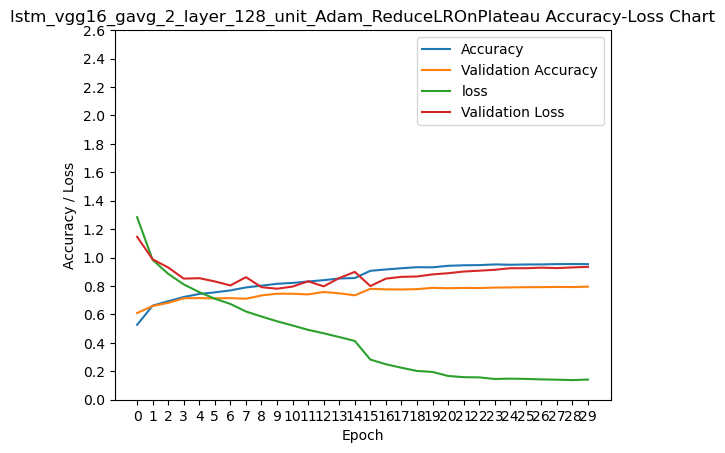

23973

In [41]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
gc.collect()

In [42]:
del X_eval, y_eval
gc.collect()
X_eval, y_eval = read_evaldataset_40f('vgg16_gavg')

y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

(678, 40, 512)
(678, 7)
170/170 [==============================] - 1s 2ms/step


(678, 7)

In [43]:
print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

Confusion Matrix: 
 [[66  1  3 12  2  6  8]
 [ 2 69  4  9  3  3  2]
 [ 7  5 63  3 16  2  4]
 [10  8  4 58  9  5  4]
 [ 5  4  8  5 62  7  5]
 [ 3  4  5 11  8 62  3]
 [ 6  1  6 10  8  2 65]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.67      0.67        98
           1       0.75      0.75      0.75        92
           2       0.68      0.63      0.65       100
           3       0.54      0.59      0.56        98
           4       0.57      0.65      0.61        96
           5       0.71      0.65      0.68        96
           6       0.71      0.66      0.69        98

    accuracy                           0.66       678
   macro avg       0.66      0.66      0.66       678
weighted avg       0.66      0.66      0.66       678



In [ ]:
#### Model setup:
Extractor = 'vgg16_gavg'
Layer = '2_layer_256_unit'
Optimizer = 'Adam'
Scheduler = 'ReduceLROnPlateau'
BatchSize = '4'

In [44]:
INPUT_SHAPE_lstm = (X_train.shape[1], X_train.shape[2])
INPUT_SHAPE_lstm

tf.keras.backend.clear_session()

inputs = Input(shape=INPUT_SHAPE_lstm)

# LSTM layer
lstm1 = LSTM(256, return_sequences=True, dropout=0.5)(inputs)

lstm12 = LSTM(128, return_sequences=False, dropout=0.5)(lstm1)

# Output layer
outputs = Dense(NUM_CLASSES, activation='softmax')(lstm12)

# Create model
model = Model(inputs, outputs)
model.summary()

mcp = ModelCheckpoint(f'lstm_{Extractor}_{Layer}_{BatchSize}_{Optimizer}_{Scheduler}', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 512)]         0         
                                                                 
 lstm (LSTM)                 (None, 40, 256)           787456    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 985,479
Trainable params: 985,479
Non-trainable params: 0
_________________________________________________________________


8390

Epoch 1/30
   1/2192 [..............................] - ETA: 1:22:28 - loss: 1.9183 - accuracy: 0.2500

2023-04-18 16:31:45.525447: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-18 16:31:45.564058: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-18 16:31:45.645006: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

2188/2192 [============================>.] - ETA: 0s - loss: 1.2926 - accuracy: 0.5291
Epoch 1: val_loss improved from inf to 1.08287, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 19s 8ms/step - loss: 1.2933 - accuracy: 0.5291 - val_loss: 1.0829 - val_accuracy: 0.6077 - lr: 0.0010
Epoch 2/30
2184/2192 [============================>.] - ETA: 0s - loss: 1.0040 - accuracy: 0.6545
Epoch 2: val_loss improved from 1.08287 to 0.99383, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 16s 7ms/step - loss: 1.0048 - accuracy: 0.6544 - val_loss: 0.9938 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 3/30
2192/2192 [==============================] - ETA: 0s - loss: 0.9083 - accuracy: 0.6896
Epoch 3: val_loss improved from 0.99383 to 0.92099, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 16s 7ms/step - loss: 0.9083 - accuracy: 0.6896 - val_loss: 0.9210 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 4/30
2186/2192 [============================>.] - ETA: 0s - loss: 0.8211 - accuracy: 0.7199
Epoch 4: val_loss improved from 0.92099 to 0.88738, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 17s 8ms/step - loss: 0.8224 - accuracy: 0.7197 - val_loss: 0.8874 - val_accuracy: 0.7085 - lr: 0.0010
Epoch 5/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.7725 - accuracy: 0.7372
Epoch 5: val_loss improved from 0.88738 to 0.84423, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 17s 8ms/step - loss: 0.7734 - accuracy: 0.7369 - val_loss: 0.8442 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 6/30
2191/2192 [============================>.] - ETA: 0s - loss: 0.7355 - accuracy: 0.7478
Epoch 6: val_loss did not improve from 0.84423
2192/2192 [==============================] - 12s 5ms/step - loss: 0.7353 - accuracy: 0.7478 - val_loss: 0.9036 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 7/30
2192/2192 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.7667
Epoch 7: val_loss did not improve from 0.84423
2192/2192 [==============================] - 11s 5ms/step - loss: 0.6839 - accuracy: 0.7667 - val_loss: 0.8742 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 8/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.7841
Epoch 8: val_loss improved from 0.84423 to 0.81835, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 15s 7ms/step - loss: 0.6292 - accuracy: 0.7843 - val_loss: 0.8183 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 9/30
2191/2192 [============================>.] - ETA: 0s - loss: 0.5991 - accuracy: 0.7918
Epoch 9: val_loss did not improve from 0.81835
2192/2192 [==============================] - 12s 5ms/step - loss: 0.5988 - accuracy: 0.7919 - val_loss: 0.9206 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 10/30
2182/2192 [============================>.] - ETA: 0s - loss: 0.5571 - accuracy: 0.8126
Epoch 10: val_loss improved from 0.81835 to 0.80475, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 17s 8ms/step - loss: 0.5567 - accuracy: 0.8127 - val_loss: 0.8047 - val_accuracy: 0.7427 - lr: 0.0010
Epoch 11/30
2189/2192 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.8230
Epoch 11: val_loss improved from 0.80475 to 0.79245, saving model to lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


INFO:tensorflow:Assets written to: lstm_vgg16_gavg_2_layer_128_unit_4_Adam_ReduceLROnPlateau/assets


2192/2192 [==============================] - 16s 7ms/step - loss: 0.5238 - accuracy: 0.8231 - val_loss: 0.7925 - val_accuracy: 0.7523 - lr: 0.0010
Epoch 12/30
2191/2192 [============================>.] - ETA: 0s - loss: 0.4947 - accuracy: 0.8280
Epoch 12: val_loss did not improve from 0.79245
2192/2192 [==============================] - 12s 5ms/step - loss: 0.4948 - accuracy: 0.8280 - val_loss: 0.8725 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 13/30
2190/2192 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.8390
Epoch 13: val_loss did not improve from 0.79245
2192/2192 [==============================] - 11s 5ms/step - loss: 0.4635 - accuracy: 0.8392 - val_loss: 0.8523 - val_accuracy: 0.7441 - lr: 0.0010
Epoch 14/30
2191/2192 [============================>.] - ETA: 0s - loss: 0.4280 - accuracy: 0.8546
Epoch 14: val_loss did not improve from 0.79245
2192/2192 [==============================] - 11s 5ms/step - loss: 0.4278 - accuracy: 0.8547 - val_loss: 0.9337 - val_a

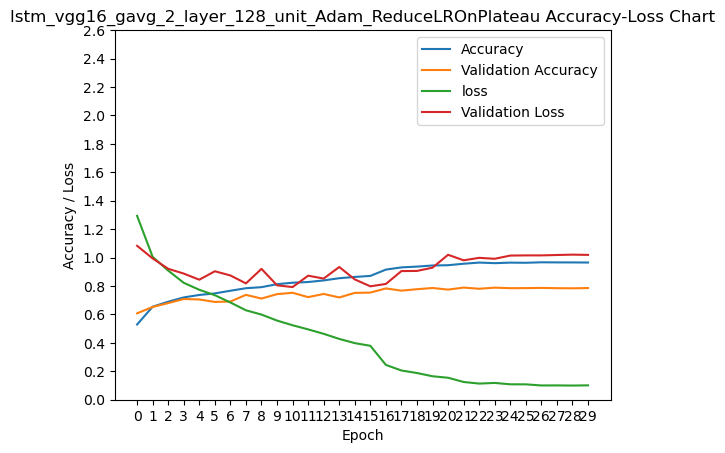

29961

In [45]:
history = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp, reduce_lr])
gc.collect()

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"lstm_{Extractor}_{Layer}_{Optimizer}_{Scheduler} Accuracy-Loss Chart")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 2.8, 0.2))
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
gc.collect()

In [46]:
y_pred = model.predict(X_eval, batch_size=4, verbose=1)
y_pred.shape

print('Confusion Matrix: \n',confusion_matrix(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))
print('\n\nClassification Report: \n',classification_report(np.argmax(y_eval, axis=1), np.argmax(y_pred, axis=1)))

170/170 [==============================] - 1s 3ms/step
Confusion Matrix: 
 [[64  2  2 14  1  6  9]
 [ 1 69  5  6  6  5  0]
 [ 7  4 73  4  7  1  4]
 [12 10  7 52  7  6  4]
 [ 5  1 11  7 65  3  4]
 [ 6  5  6 15  6 53  5]
 [ 9  1  7  9  2  3 67]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.62      0.65      0.63        98
           1       0.75      0.75      0.75        92
           2       0.66      0.73      0.69       100
           3       0.49      0.53      0.51        98
           4       0.69      0.68      0.68        96
           5       0.69      0.55      0.61        96
           6       0.72      0.68      0.70        98

    accuracy                           0.65       678
   macro avg       0.66      0.65      0.65       678
weighted avg       0.66      0.65      0.65       678

